# Data science test: Direct marketing optimization

Use the data to maximize revenue from direct marketing campaigns.

### Data:
For the analysis, the following tables are available:

1. Social-demographic data (age, gender, tenure with the bank)
2. Products owned and their corresponding volumes (current account, savings account, mutual funds, overdraft, credit card, consumer loan)
3. Inflow/outflow on current accounts, and aggregated card turnover (monthly average over the past 3 months)
4. Actual sales and revenues for 60% of clients (training set)

Import packages

In [55]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
#from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
RANDOM_STATE = 42

In [2]:
# Read in Excel file
dfs = pd.ExcelFile("./DataScientist_CaseStudy_Dataset.xlsx")
dfs.sheet_names

['Description',
 'Soc_Dem',
 'Products_ActBalance',
 'Inflow_Outflow',
 'Sales_Revenues']

# Data Pre-processing & EDA

Before conducting exploratory data analysis (EDA), it is important to check for missing or corrupted values.

In this step, we identify any entries that appear to be invalid and address them, providing justification for the approach taken to resolve each issue.

In [3]:
# Since the task is focused on the client, it is logical to use the Client as the index.
def indexWithClient(df):
    df.index = df.Client
    df = df.drop("Client", axis=1)
    return df.sort_index()

In [4]:
df_Soc_Dem = indexWithClient(dfs.parse(dfs.sheet_names[1]))              # "Soc_Dem" sheet
df_Products_ActBalance = indexWithClient(dfs.parse(dfs.sheet_names[2]))  # "Products_ActBalance" sheet
df_Inflow_Outflow = indexWithClient(dfs.parse(dfs.sheet_names[3]))       # "Inflow_Outflow" sheet
df_Sales_Revenues = indexWithClient(dfs.parse(dfs.sheet_names[4]))       # "Sales_Revenues" sheet

In [5]:
# Concatenate all the sheets into a one dataframe
df = pd.concat([df_Soc_Dem, df_Products_ActBalance, df_Inflow_Outflow, df_Sales_Revenues], axis=1)
df.shape

(1615, 35)

In [6]:
# Get NaN counts
df.isna().sum()

Sex                                3
Age                                0
Tenure                             0
Count_CA                           0
Count_SA                        1189
Count_MF                        1309
Count_OVD                       1196
Count_CC                        1445
Count_CL                        1480
ActBal_CA                          0
ActBal_SA                       1189
ActBal_MF                       1309
ActBal_OVD                      1196
ActBal_CC                       1445
ActBal_CL                       1480
VolumeCred                        28
VolumeCred_CA                     28
TransactionsCred                  28
TransactionsCred_CA               28
VolumeDeb                         28
VolumeDeb_CA                      28
VolumeDebCash_Card                28
VolumeDebCashless_Card            28
VolumeDeb_PaymentOrder            28
TransactionsDeb                   28
TransactionsDeb_CA                28
TransactionsDebCash_Card          28
T

There are 3 missing values (NaNs) in the 'Sex' field of the 'Soc_Dem' sheet. Several approaches could be used to handle this issue, such as estimating the missing values based on similar instances, using mean/median for numerical fields, or retaining the missing data. However, since these 3 missing instances account for only a small fraction of the dataset (1615 entries in total), we will choose to exclude these clients from the analysis.

In [7]:
df.dropna(subset=['Sex'], inplace=True)

# also replace the categorical M/F Sex indicator with a numerical value (F=0, M=1)
df["Sex"] = pd.Categorical(df["Sex"]).codes 

We observe that some clients have NaN values for certain types of accounts, with corresponding balances also being NaN. This likely indicates that the client does not possess such accounts. Therefore, we assume that these NaN account entries represent accounts with a balance of 0, and we set these values to 0 accordingly. However, in certain situations, it may be more appropriate to represent the absence of an account in a different way.

In [8]:
df.update(df[['Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL']].fillna(0))
df.update(df[['ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']].fillna(0))

Similarly, if a client has no recorded transactions or transaction volume over the past three months, we assume that no transactions have occurred. As a result, the NaN values for these entries will be set to 0.

In [9]:
df.update(df[['VolumeCred', 'VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
              'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder']].fillna(0))
df.update(df[['TransactionsCred', 'TransactionsCred_CA', 'TransactionsDeb', 'TransactionsDeb_CA',
              'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']].fillna(0))

It would also be beneficial to check for duplicate entries in the dataset, as they would not contribute new information for the models and could potentially introduce bias into the results.

In [10]:
len(df[df.duplicated()])

0

No duplicates were found.
The Count_* and Transactions* fields should only contain integer values. After confirming this, these fields were converted from floating point numbers to integers.

In [11]:
int_cols = ['Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL',
            'TransactionsCred', 'TransactionsCred_CA', 'TransactionsDeb', 'TransactionsDeb_CA',
            'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']

for col in int_cols:
    df[col] = df[col].astype('int64')

In [12]:
# show all columns
with pd.option_context('display.max_columns', None):
    display(df.describe())

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000
mean,0.531017,42.851737,101.408189,1.078784,0.307692,0.887717,0.259926,0.105459,0.099256,2438.101514,4016.339385,3894.767521,32.867560,37.047284,354.889372,1793.398291,1481.087660,5.450372,4.193548,1668.700012,1435.360060,253.704438,148.033282,703.702178,15.732630,13.359801,1.956576,5.151985,4.518610,0.199586,0.250259,0.298862,1.928997,2.718437,3.595933
std,0.499192,18.565762,64.903220,0.333328,0.567802,3.875201,0.438730,0.307239,0.361148,7078.342695,17925.062600,34900.056682,158.067054,191.040551,1680.235782,5823.775658,4629.225173,6.346161,4.936444,5148.006954,4252.121691,752.533315,309.867961,3191.368570,16.246964,12.989881,2.701468,8.347502,5.201611,0.399896,0.433386,0.457996,9.953503,17.711309,7.741740
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.479286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.000000,44.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.267589,0.000000,0.000000,0.000000,0.000000,0.000000,214.286071,192.168839,2.000000,2.000000,202.077143,188.879464,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,41.000000,97.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,461.399464,0.000000,0.000000,0.000000,0.000000,0.000000,638.849107,601.400714,3.000000,3.000000,641.064107,607.785714,71.428571,16.455357,170.553571,11.000000,10.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,57.000000,151.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2174.675893,0.009821,0.000000,0.000000,0.000000,0.000000,1406.314464,1288.184286,6.000000,4.000000,1386.116964,1305.245804,342.857143,174.108036,493.188571,22.000000,19.000000,3.000000,7.000000,7.000000,0.000000,0.500000,1.000000,0.000000,0.035714,4.625000
max,1.000000,97.000000,273.000000,4.000000,5.000000,79.000000,1.000000,1.000000,5.000000,171575.889643,389883.830714,761235.504286,2055.325357,3522.233571,20749.294643,107703.804286,98717.675000,63.000000,48.000000,119906.503929,73477.932500,23571.428571,3637.616786,72278.782143,102.000000,83.000000,25.000000,60.000000,34.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357


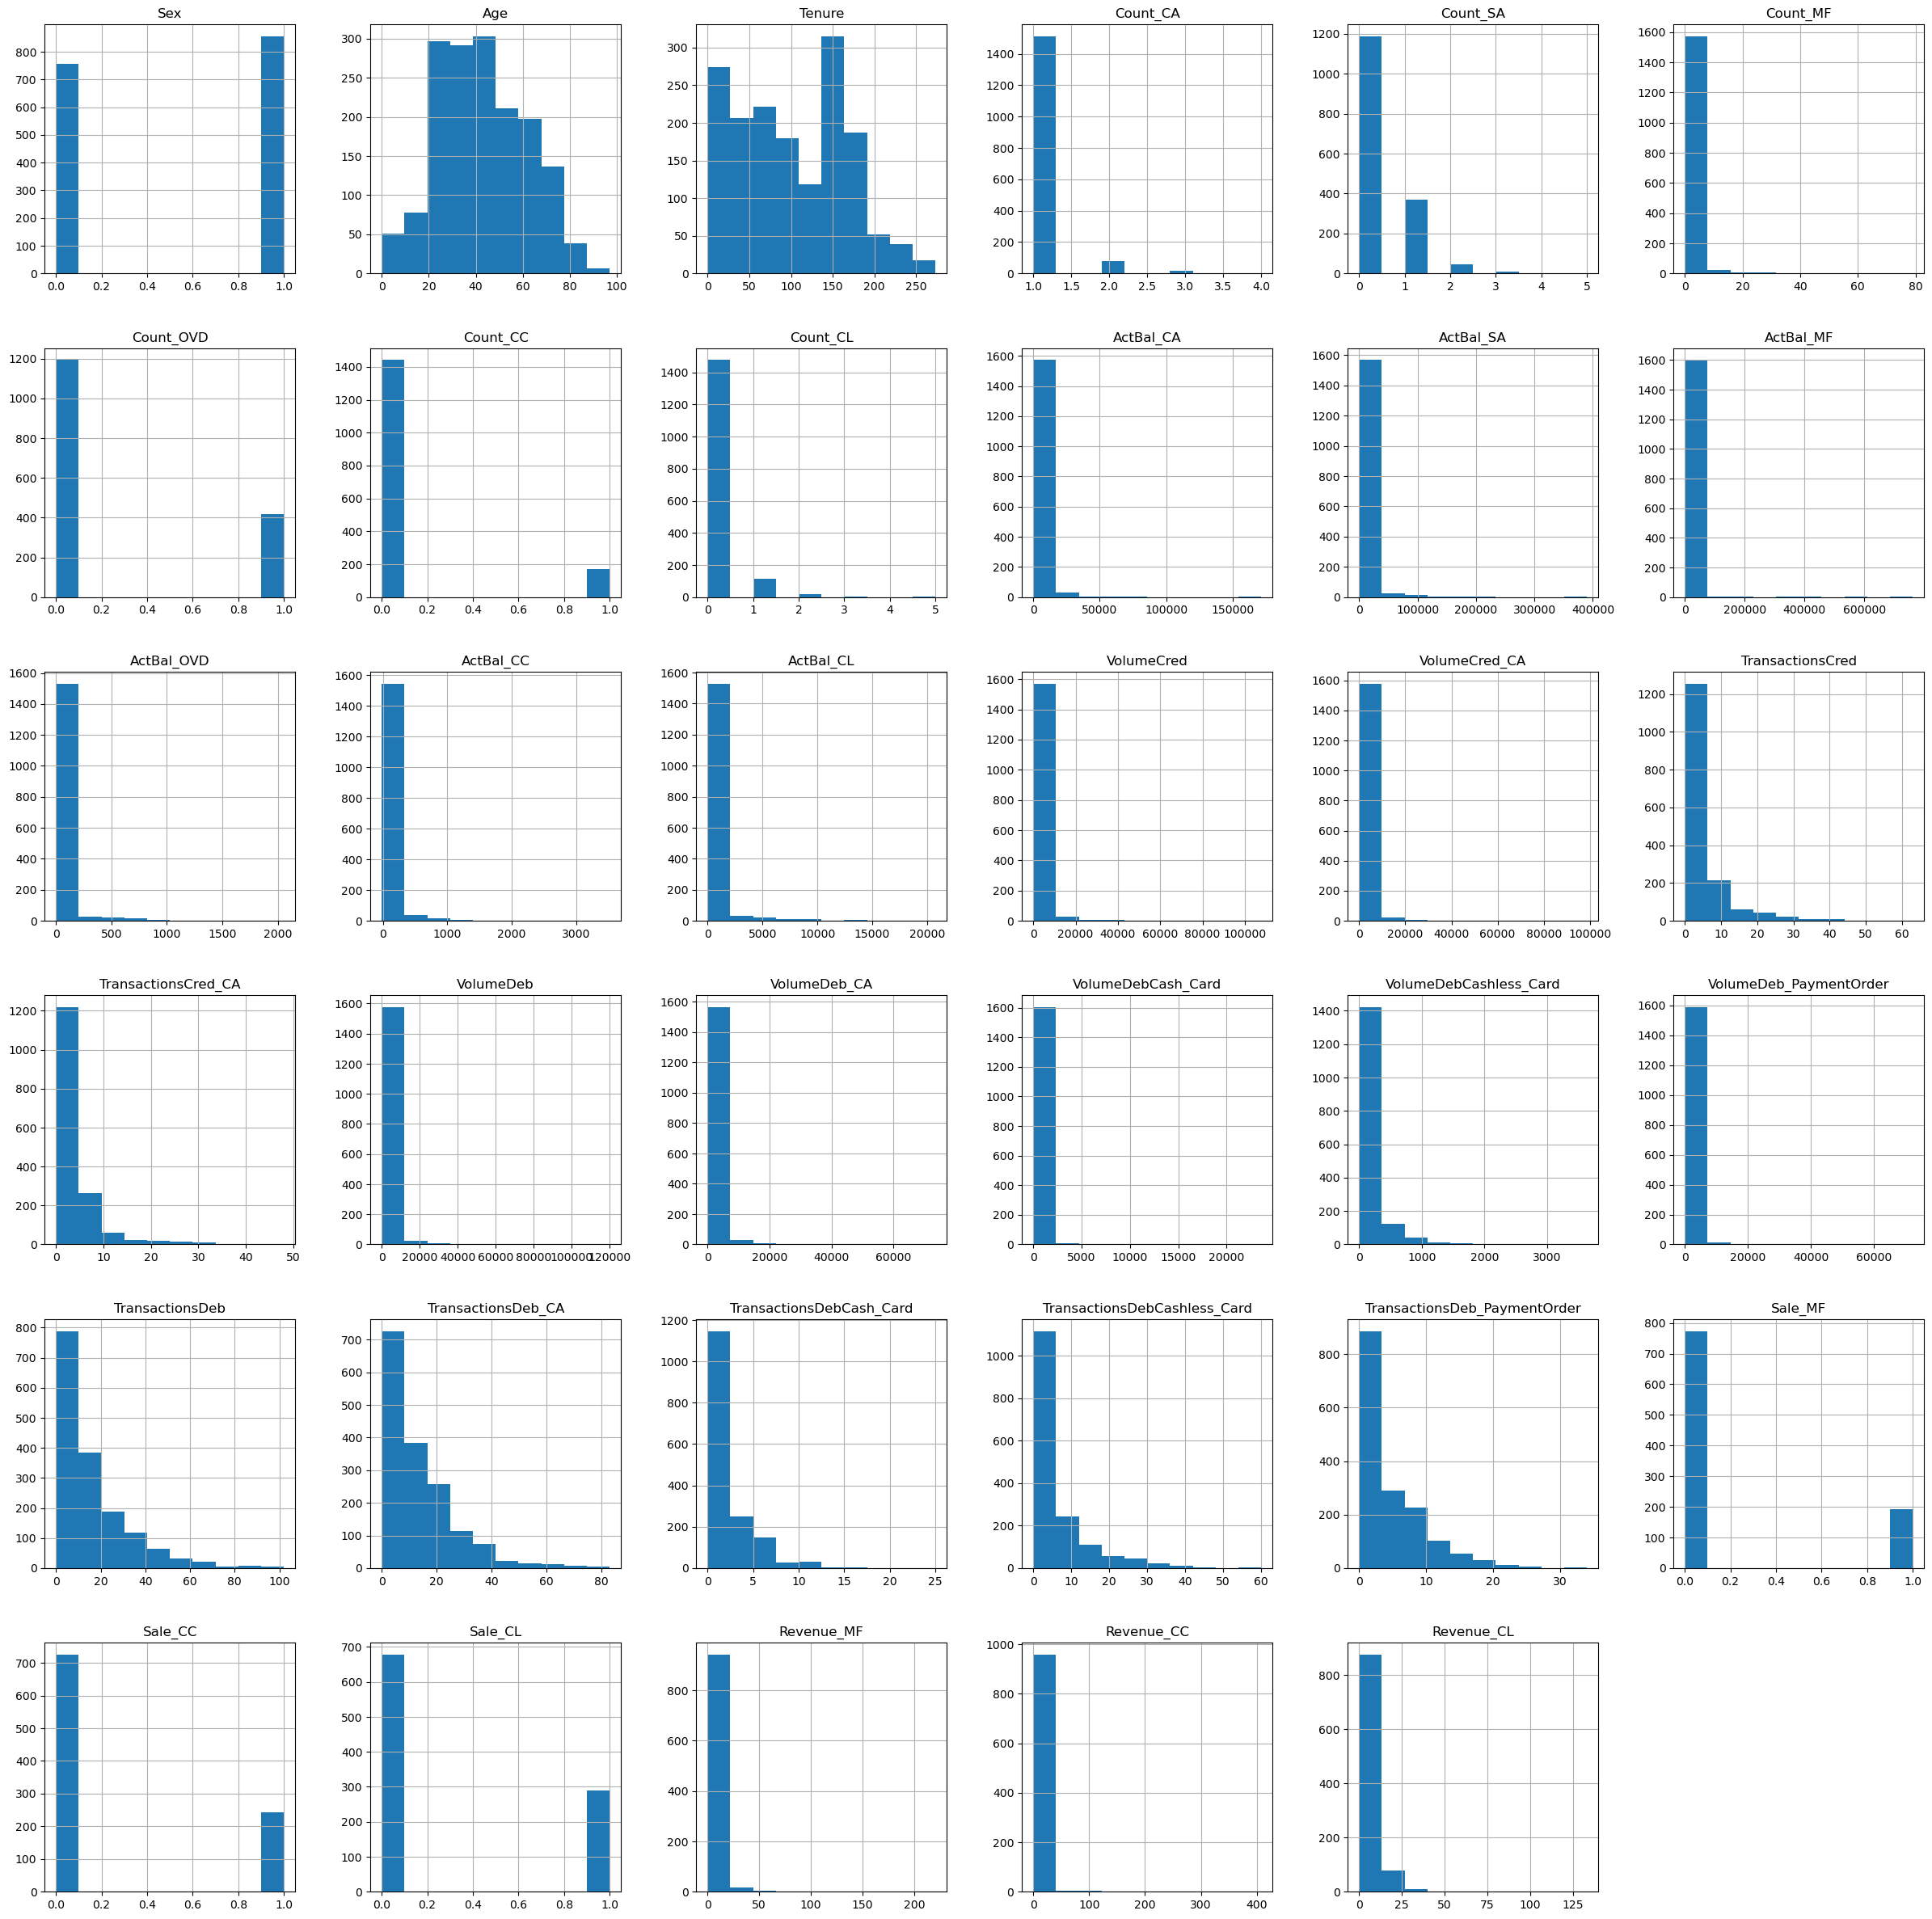

In [13]:
# Examine the distribution of values for each attribute by categorizing them into bins.
df.hist(figsize=(30,30))
plt.show()  

The first notable observation is the presence of some unusual values in the 'Age' field of account holders. Let's investigate this further.

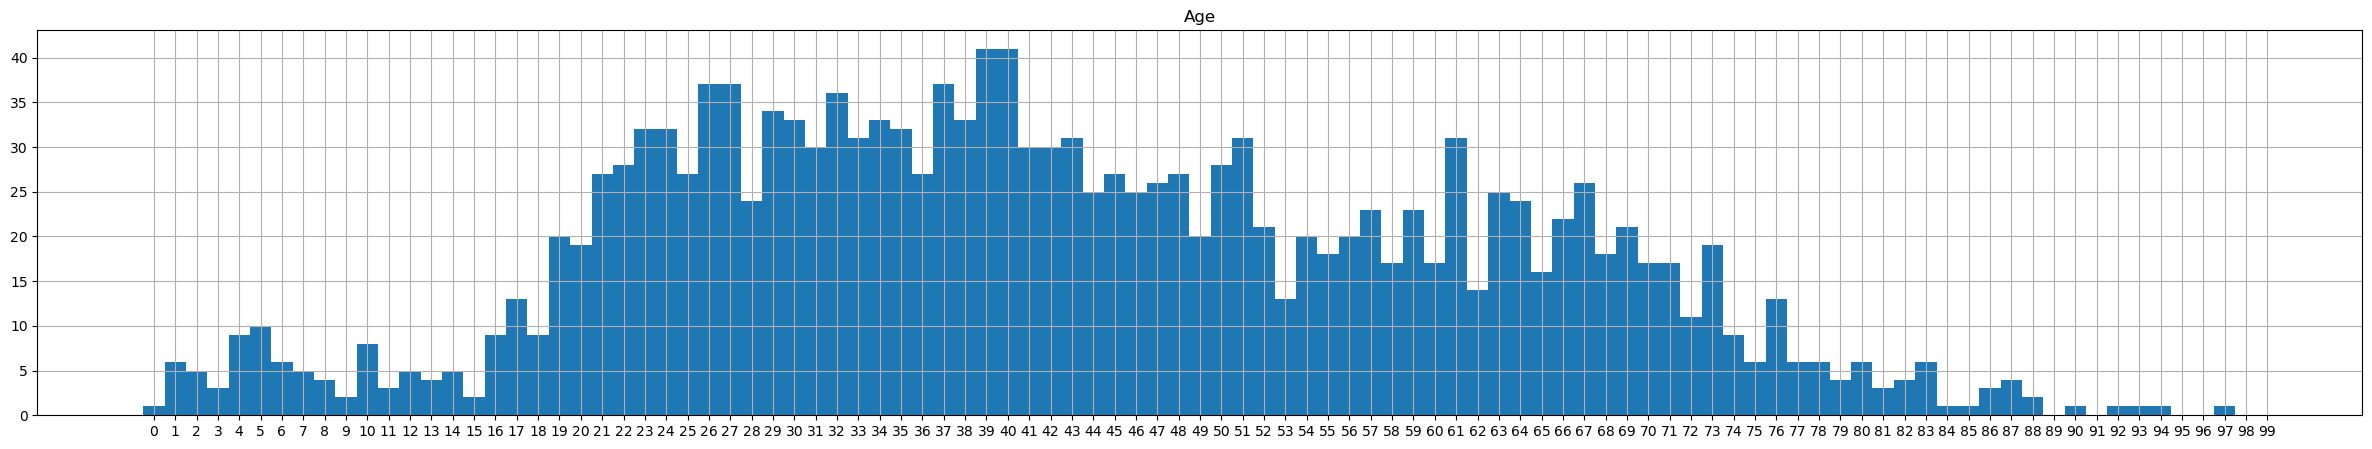

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
158,1,0,152,1,1,0,0,0,0,326.630357,...,13,0,13,0,0.0,0.0,0.0,0.0,0.000000,0.000000
316,0,1,211,1,0,0,0,0,0,22.733571,...,21,6,1,9,0.0,0.0,1.0,0.0,0.000000,15.015357
638,1,1,31,1,0,0,1,0,0,89.250000,...,9,1,4,1,0.0,0.0,0.0,0.0,0.000000,0.000000
391,1,1,16,1,0,0,0,1,1,172.581429,...,18,4,0,6,0.0,0.0,0.0,0.0,0.000000,0.000000
322,0,1,92,1,1,0,0,0,0,2175.270000,...,2,0,0,0,0.0,1.0,0.0,0.0,1.785714,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,1,17,27,1,1,1,0,0,0,156.846429,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
729,1,17,85,1,1,1,1,0,0,2082.308929,...,14,0,0,11,0.0,1.0,1.0,0.0,3.502143,28.148929
733,1,17,4,1,1,0,0,0,0,5.706786,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df[['Age']].hist(bins=np.arange(0, 100), figsize=(30,5),  align="left")
plt.xticks(np.arange(0, 100))
plt.show()

df[df['Age'] < 18].sort_values(by='Age')

An interesting issue was discovered: around 6% of account holders are listed as being younger than 18 years of age. While it is theoretically possible for an underage person to hold an account, legal restrictions limit the types of actions they can perform, meaning these accounts are not full personal accounts.

For example, accounts with mutual funds or overdrafts are not allowed, credit cards cannot be issued until the account holder turns 18 and saving account can be opened with parents. Additionally, in some cases, the age of the account holder appears to be less than their tenure with the bank, which further raises concerns.

In [15]:
with pd.option_context('display.max_rows', 10):
    display(df[df['Age'] < df['Tenure']//12].loc[:, 'Age':'Tenure'])

,Age,Tenure
Client,,
23,4,160
158,0,152
225,14,187
300,5,87
316,1,211
...,...,...
1561,12,204
1569,3,152
1583,8,151


As a result, entries with clients below the age of 18 in this dataset were treated as random errors in the records. Several options for handling these discrepancies were considered:

The entries could be removed from the dataset entirely, as the data points they contain may be inaccurate.
The Age and/or Tenure fields could be cleared (set to NaNs), and a model capable of handling NaN values could be selected.
The Age and/or Tenure fields could be recomputed, using techniques like mean/median imputation or more advanced methods such as MICE or kNN, which would estimate the missing values based on the rest of the dataset.
These options become more appealing as the dataset size increases, since computing new values from existing data would introduce less bias in a larger dataset, minimizing the impact on prediction quality. However, since our dataset only contains approximately 1600 entries and for simplicity, the first approach was chosen: entries where the account holder is below 18 years old or where the account holder's age is less than their tenure with the bank were removed.

In [16]:
df.drop(df[df.Age < 18].index, inplace=True)
df.drop(df[df['Age'] < df['Tenure']//12].index, inplace=True)

Finally, the remaining NaN values signify that certain client instances do not have corresponding sales and revenue data. These missing values will need to be predicted. Entries with non-NaN values are considered part of the training set, while those with NaNs will serve as input for the predictive models. As noted in the task description, the instances with non-NaN values make up 60% of the dataset.

In [17]:
null_mask = df['Sale_MF'].isnull()
df_train = df[~null_mask]
df_guess = df[null_mask]
# sanity check that the split was right
assert(df_train.shape[0] + df_guess.shape[0] == df.shape[0])
# drop empty columns (values to be predicted)
df_guess = df_guess.drop(columns=['Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'])

#  Modelling

The task involves developing propensity models for three products: consumer loans, credit cards, and mutual funds. Specifically, the goal is to:

Predict which customers will purchase a consumer loan and estimate the expected revenue.
Predict which customers will purchase a credit card and estimate the expected revenue.
Predict which customers will purchase a mutual fund and estimate the expected revenue.
Given that the bank can only contact 15% of its clients with a marketing offer, and each client can be targeted only once, the objective is to identify which clients should receive which offer in order to maximize the overall revenue.

## Consumer Loan Data

Let's start by exploring the data related to consumer loans. Predicting which customers will purchase consumer loans is a classification task. By plotting the distribution of attribute values against the target class, we can uncover valuable insights that may guide our expectations.

In [18]:
# Plotting function that visualises difference among attribute values in binary classification tasks
def compare_binary_class_difference(class_name):
    classes = sorted(df_train[class_name].unique())
    
    plt.figure(figsize=(30,25))
    # Iterate through all attributes
    for i, col in enumerate(df_train.columns):
        # Skip the output classes for this evaluation predict (i.e. `y`)
        if "Sale_" in col or "Revenue_" in col:
            continue
        plt.subplot(6, 5, i+1)
        plt.hist([df_train.loc[df_train[class_name] == x, col] for x in classes],
                 label=classes)
        plt.legend([class_name + "=0", class_name + "=1"])
        plt.title(col)
    plt.show()

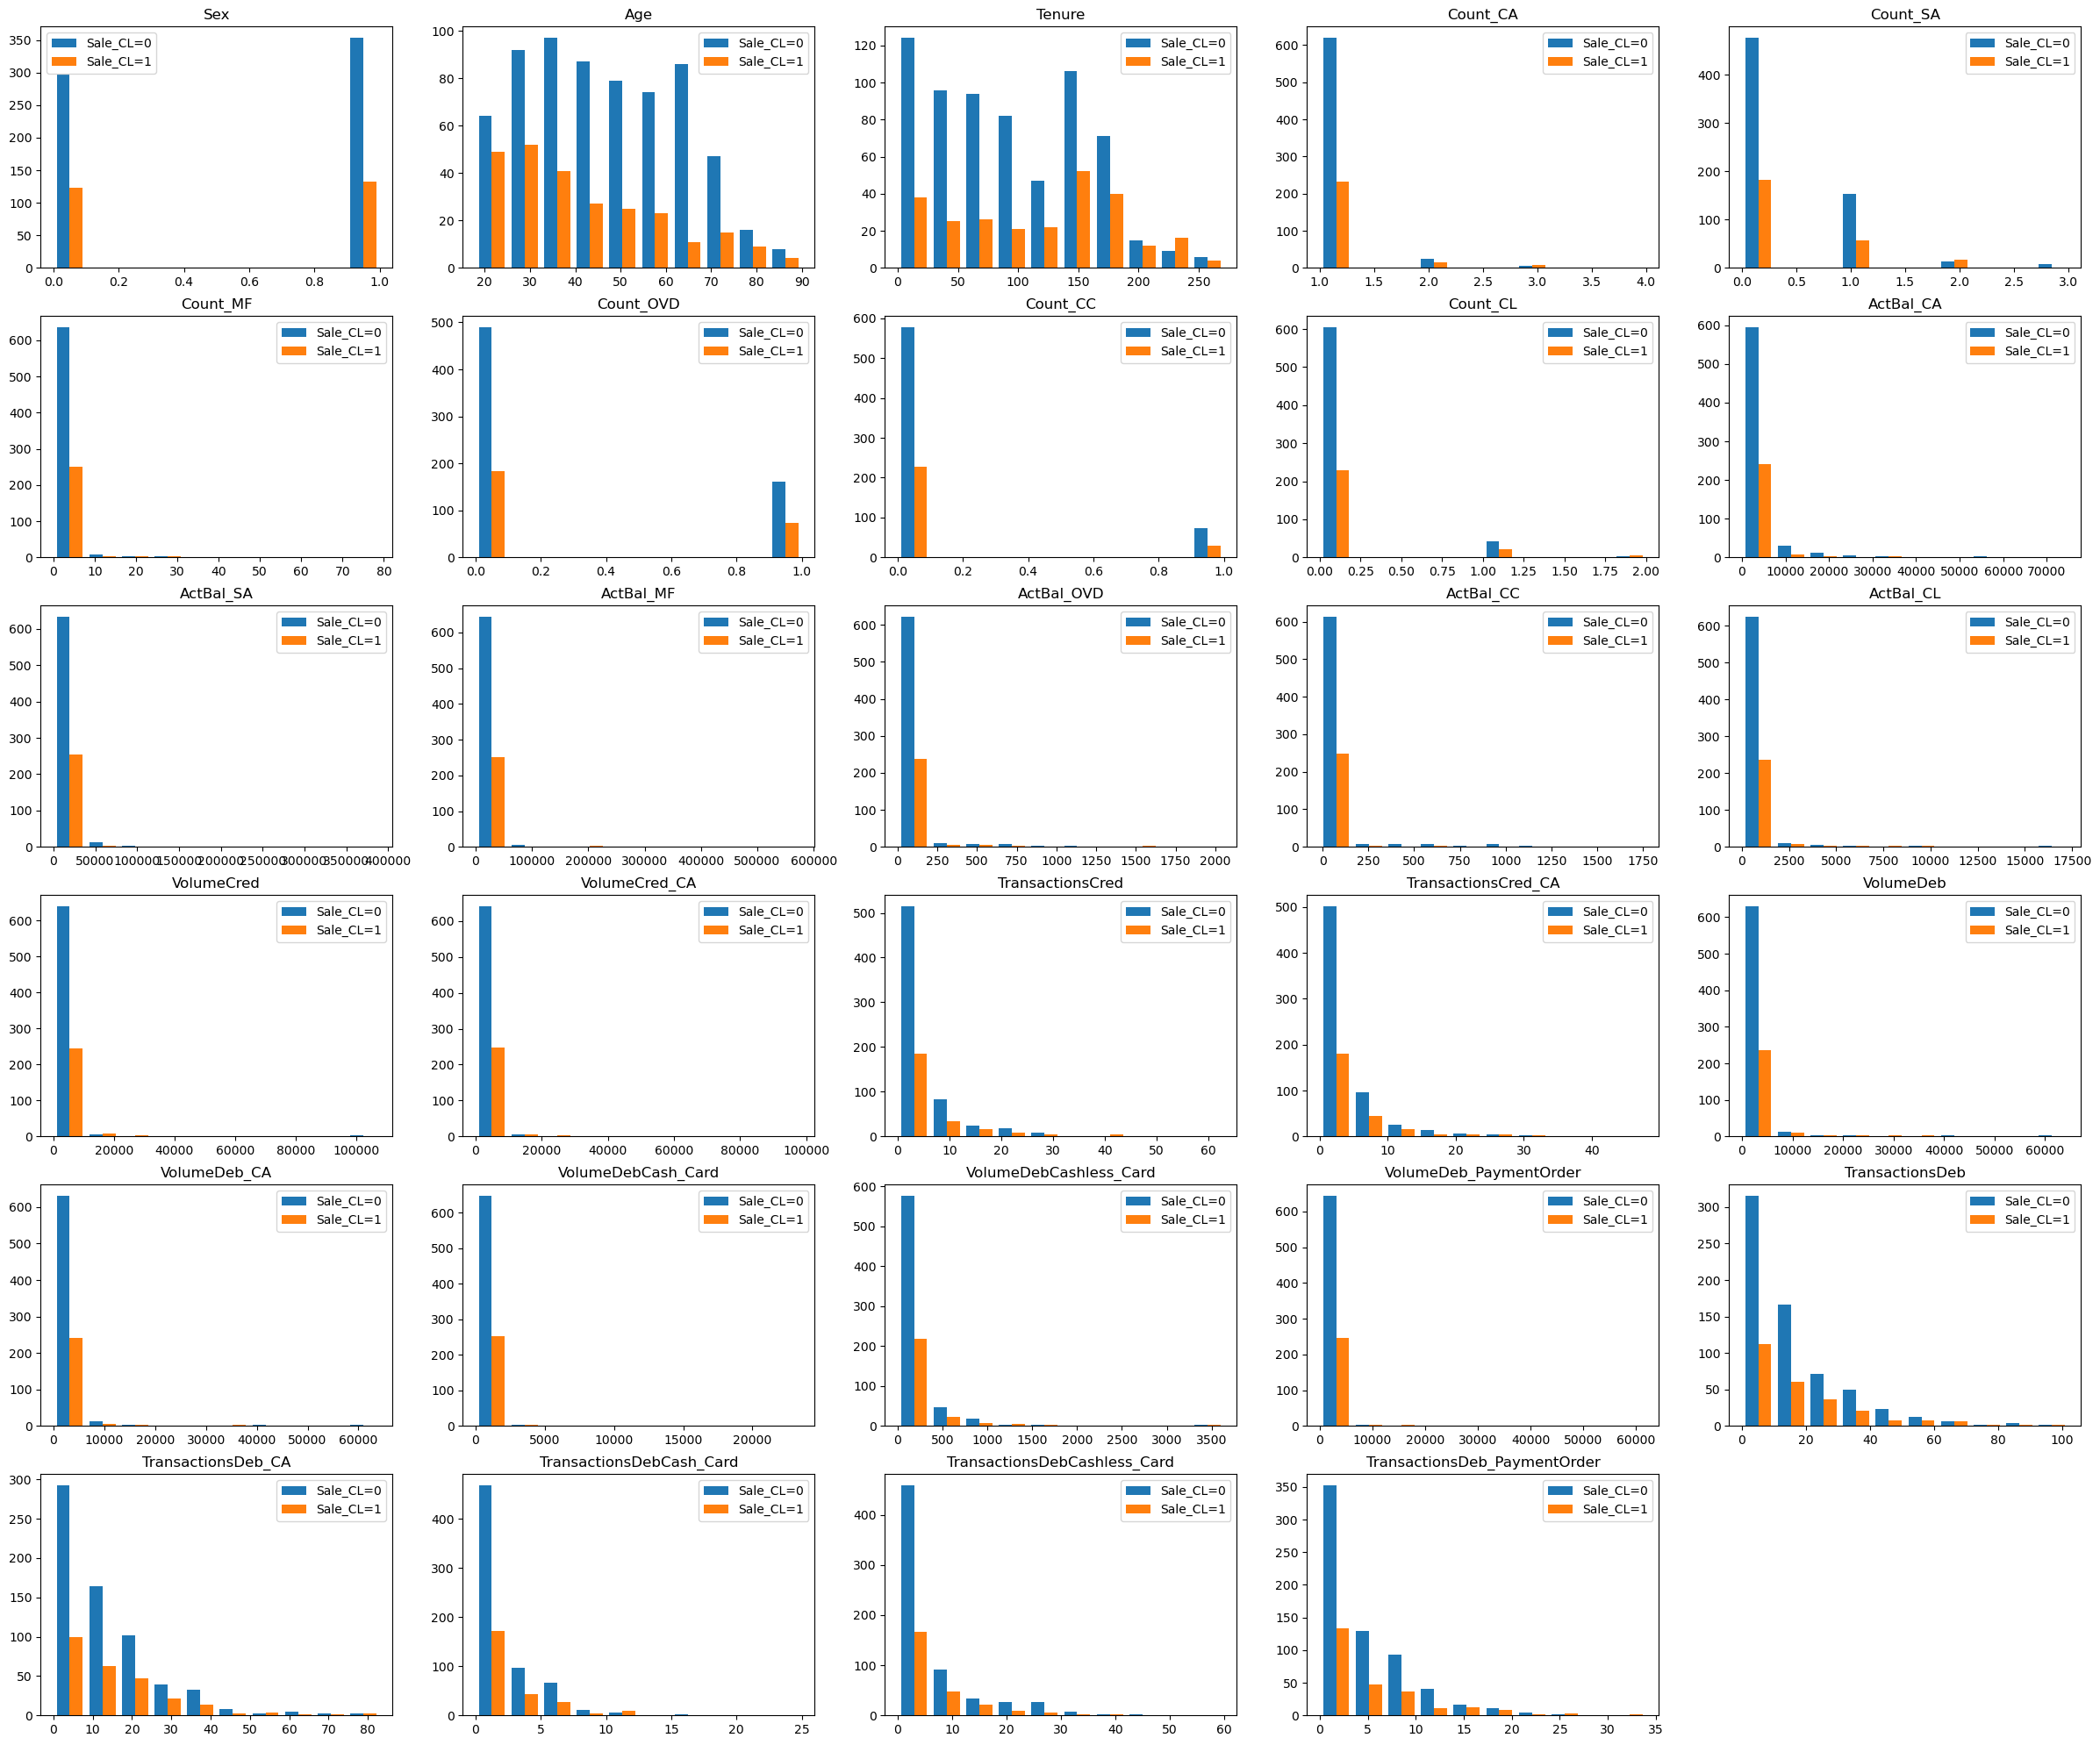

In [19]:
compare_binary_class_difference('Sale_CL')

Several interesting trends emerge from the data. Consumer loans appear to be more common among both younger and older clients. Additionally, clients who have been with the bank for a longer period also show a higher likelihood of having a consumer loan. Furthermore, clients with a higher monthly volume of debit transactions via payment order are more likely to hold a consumer loan.

When selecting features for the model, it is important to exclude some independent variables that may have been influenced by the outcome we are trying to predict. For example, in the case of predicting consumer loan sales, features such as Count_CL and ActBal_CL could be impacted by the dependent variables Sale_CL and Revenue_CL, so these features will be excluded. It might also be worth considering whether TransactionsCred and VolumeCred should be excluded, but the variable descriptions do not provide enough clarity on this.

For more complex models, it may be useful to delve deeper into which features to retain, particularly considering additional data available to the bank. For example, clients who have successfully repaid a previous loan may be more inclined to take out another loan. On the other hand, clients with other active loans might be deemed higher risk by the bank's scoring system, making them less favorable candidates for a new consumer loan offer.

In [20]:
features_CL = ['Sex', 'Age', 'Tenure',
               'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC',
               'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC',
               'VolumeCred', 'VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
               'TransactionsCred', 'TransactionsCred_CA', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
df_train_CL_X = df_train[features_CL]
df_train_Sale_CL_Y = df_train[['Sale_CL']].to_numpy().flatten()
df_train_Revenue_CL_Y = df_train[['Revenue_CL']].to_numpy().flatten()

To capture these and other patterns in the data, we will build a model. Random forests are a strong initial choice since they can handle both classification (for predicting purchases) and regression (for estimating revenue). They are widely used and do not require data normalization, allowing us to proceed directly with modeling.

In [21]:
def train_classification_model(df_X, df_Y, **hyperparams):
    X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y,
                                                        test_size=0.2,
                                                        random_state=RANDOM_STATE)
    
    # because the classes are imbalanced, we need to compute class weights
    class_weights = compute_class_weight('balanced', classes=[0, 1], y=Y_train)

    clf = RandomForestClassifier(**hyperparams,
                                 class_weight={c: class_weights[c] for c in [0,1]},
                                 random_state=RANDOM_STATE)
    clf.fit(X_train, Y_train)
    
    Y_pred_test = clf.predict_proba(X_test)[:, 1]
    Y_pred_train = clf.predict_proba(X_train)[:, 1]

    print('Training set metrics:')
    print('Accuracy: ', accuracy_score(Y_train, np.round(Y_pred_train)))
    print('Precision:', precision_score(Y_train, np.round(Y_pred_train)))
    print('Recall:   ', recall_score(Y_train, np.round(Y_pred_train)))
    print('AUC:      ', roc_auc_score(Y_train, Y_pred_train))
    print("-----------------------------")
    print('Test set metrics:')
    print('Accuracy: ', accuracy_score(Y_test, np.round(Y_pred_test)))
    print('Precision:', precision_score(Y_test, np.round(Y_pred_test)))
    print('Recall:   ', recall_score(Y_test, np.round(Y_pred_test)))
    print('AUC:      ', roc_auc_score(Y_test, Y_pred_test))
    
    return clf

To ensure high-quality results, several key steps must be taken when training a machine learning model. Hyperparameter tuning is crucial for optimizing performance, and in this case, a grid search approach was employed. Given the imbalance in the dataset, adjustments were made to penalize instances of the more prevalent class.

Model evaluation is performed on an unseen test dataset to enhance generalization. Choosing the right evaluation metrics is also essential. Here, we assess performance using accuracy (the percentage of correct predictions), the balance between precision (the proportion of correct positive predictions out of all positive predictions made) and recall (the proportion of correct positive predictions out of all actual positive instances), as well as area under the curve (AUC), which measures the model's ability to distinguish between positive and negative cases.

In [22]:
m_Sale_CL = train_classification_model(df_train_CL_X, df_train_Sale_CL_Y,
                                       criterion='entropy',
                                       n_estimators=50,
                                       min_samples_split=100,
                                       min_samples_leaf=5,)

Training set metrics:
Accuracy:  0.8066298342541437
Precision: 0.6380090497737556
Recall:    0.7014925373134329
AUC:       0.8555121143802975
-----------------------------
Test set metrics:
Accuracy:  0.7142857142857143
Precision: 0.5294117647058824
Recall:    0.4909090909090909
AUC:       0.6989262705798138


The trained consumer loan sale model exhibits slight overfitting but delivers results that are sufficient for our needs. Exploring alternative models, architectures, and feature selections may yield further improvements.

Compared to a random-guessing baseline, the model demonstrates a substantial enhancement in correctly classifying the target based on the input features.

To gain deeper insights into how the model interprets the dataset, the importance of each attribute is assessed. This process disrupts the relationship between a feature and the target by measuring the decrease in the model's performance when the values of a single feature are randomly shuffled.

In [23]:
def visualize_permutation_importance(m, df_X, df_Y):
    result = permutation_importance(m,
                                    df_X, df_Y,
                                    n_repeats=10, n_jobs=2,
                                    random_state=RANDOM_STATE)
    
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
               labels=df_X.columns[sorted_idx],
                vert=False)
    ax.set_title("Permutation Importances")
    fig.tight_layout()
    plt.show()
    
    return sorted_idx

/var/folders/n4/vr9czyr51kz3wp717sbrf_3c0000gp/T/ipykernel_79166/2226445234.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T,


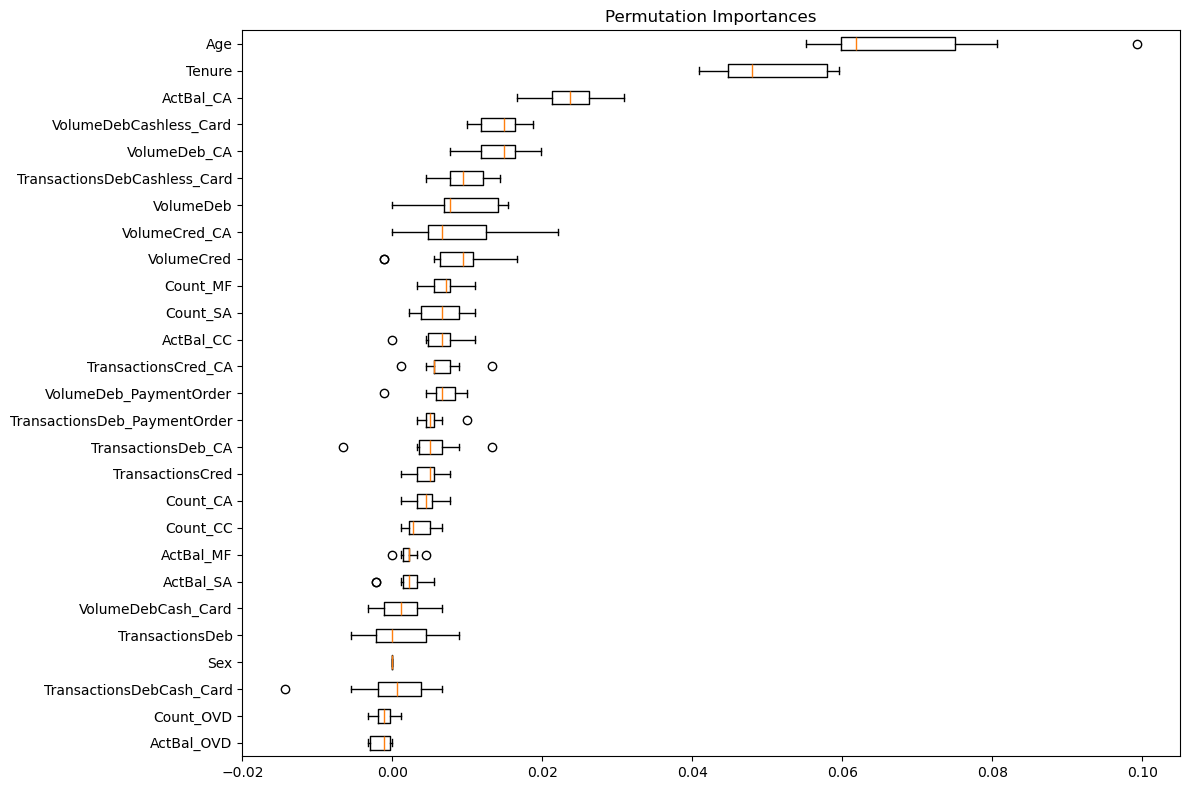

In [24]:
feature_importance_Sale_CL = visualize_permutation_importance(m_Sale_CL, df_train_CL_X, df_train_Sale_CL_Y)

The results indicate that the most influential factors in the consumer loan sale model are the client's age and tenure with the bank, followed by current account balance and other key attributes.

Partial dependence plots (PDPs) provide a valuable tool for gaining insights into a predictive model. These plots illustrate the expected target response as a function of specific features. While PDPs assume independence between the target features and the remaining features—an assumption that may not always hold—they still reveal important trends in how feature values influence the model’s predictions.

For clarity, only the top eight most significant features, as determined by the permutation importance algorithm, are displayed.

In [25]:
def visualize_partial_dependence(m, df_X, sorted_idx, threshold=8):
    fig, ax = plt.subplots(figsize=(30, 5))
    ax.set_title("%d most important features" % threshold)
    plot_partial_dependence(m, df_X,
                            df_X.columns[sorted_idx][::-1][:threshold],
                            n_cols=threshold,
                            n_jobs=-1,
                            grid_resolution=100, ax=ax)

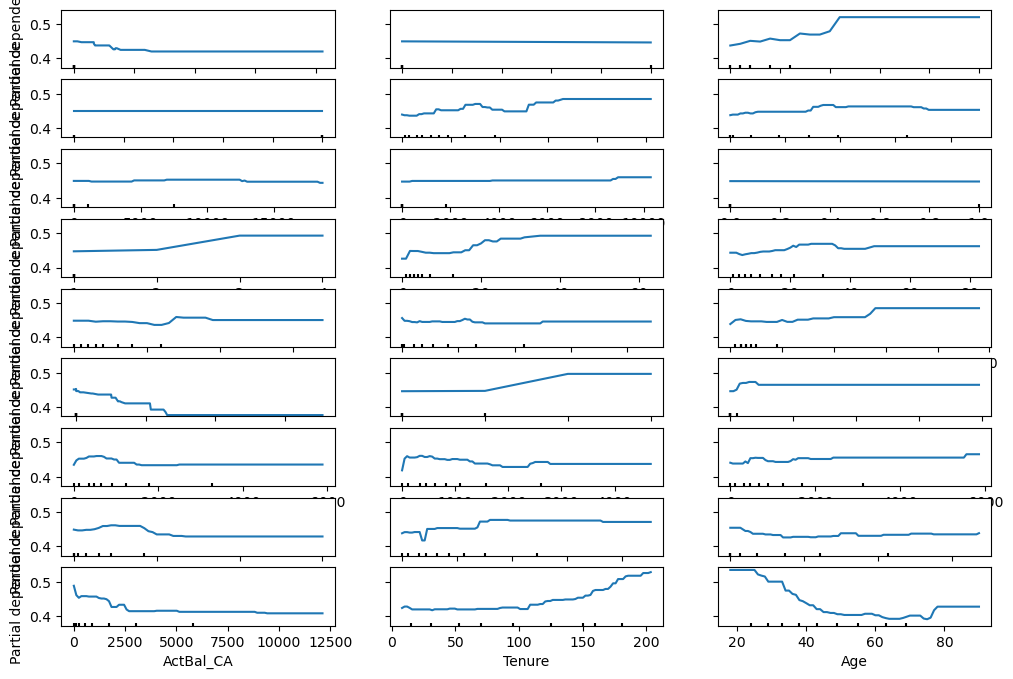

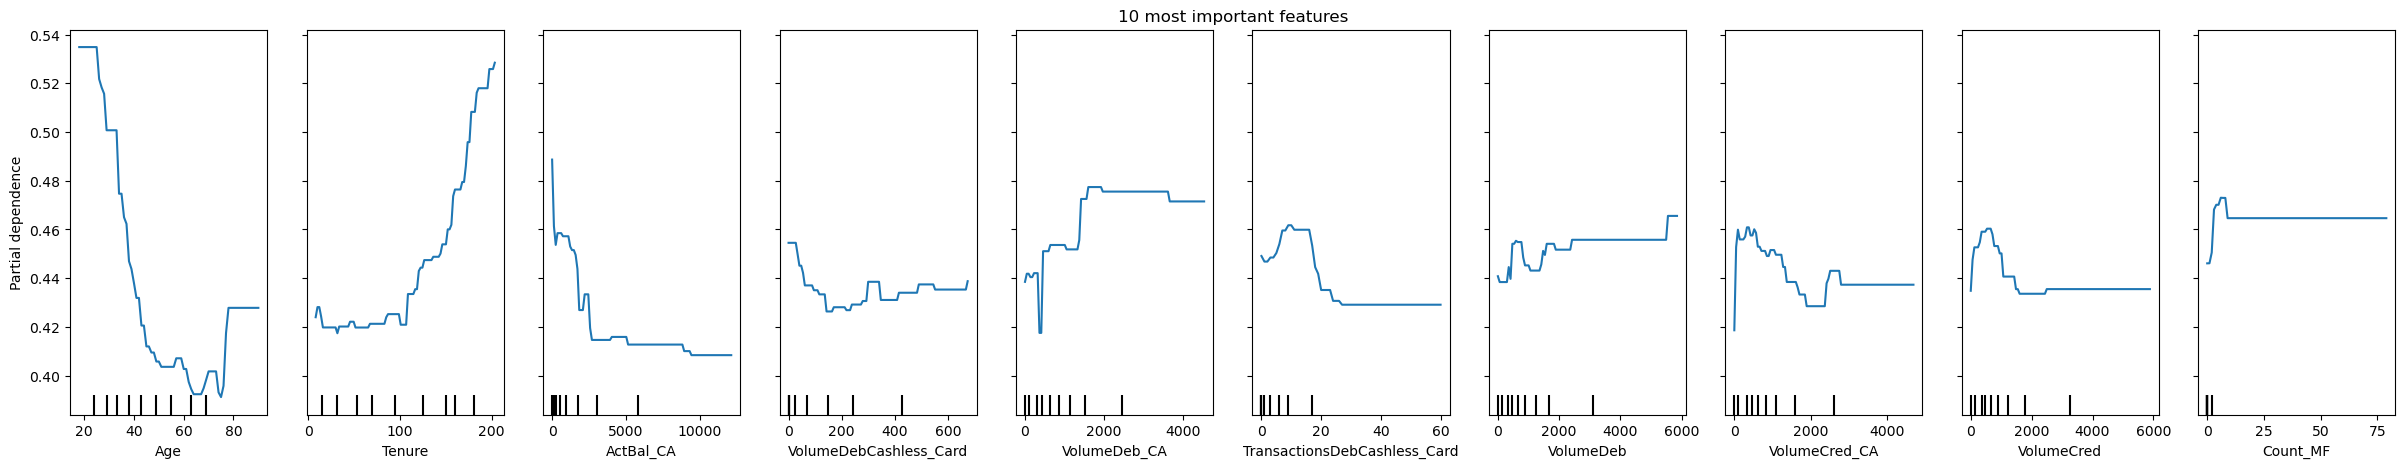

In [56]:
#from sklearn.inspection import PartialDependenceDisplay

# Assuming `model` is your trained model and `X` is your feature set
features = [0, 1]  # Change based on the feature indices you want to analyze
PartialDependenceDisplay.from_estimator(m_Sale_CL, df_train_CL_X, feature_importance_Sale_CL)

visualize_partial_dependence(m_Sale_CL, df_train_CL_X, feature_importance_Sale_CL)

At first glance, we can see how clients at either end of the age spectrum have the tendency to be favoured by the model for consumer loan sale. This is also true for clients with longer tenure at the bank. Both of these trends confirm the expectations of the data examination at the beginning of this section.

Key factors influencing consumer loan purchases include Age, Tenure, ActBal_CA (current account balance), VolumeDebCashless_Card (monthly debit cashless transactions via card), and VolumeDeb_CA (monthly debit turnover on current accounts).

Clients most inclined to take a consumer loan tend to fall into two categories: younger customers or long-standing, retired clients. They typically maintain low balances in their current and savings accounts, frequently engage in small cashless transactions, and exhibit high turnover in their current accounts.

### Consumer Loan Revenue

A similar approach was used to develop the revenue model for consumer loan offers. However, unlike the sale model, which was a classification task, the revenue model is framed as a regression task. While Random Forests were employed in both cases, the training process for the revenue model differs accordingly.

In [27]:
def train_regression_model(df_X, df_Y, **hyperparams):
    X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y,
                                                        test_size=0.2,
                                                        random_state=RANDOM_STATE)
    reg = RandomForestRegressor(**hyperparams,
                                random_state=RANDOM_STATE)
    reg.fit(X_train, Y_train)
    
    Y_pred_train = reg.predict(X_train)
    Y_pred_test = reg.predict(X_test)
    print('RMSE (Training set): %0.3f' % mean_squared_error(Y_pred_train, Y_train, squared=False))
    print('RMSE (Test set):     %0.3f\n' % mean_squared_error(Y_pred_test, Y_test, squared=False))
    
    return reg

The key aspect to note here is how the model's performance is assessed. The evaluation metric used is the root-mean-square error (RMSE), which measures the difference between the actual and predicted values.

RMSE is calculated as the square root of the average of squared errors, meaning that errors contribute to the final score based on their magnitude. Consequently, larger errors have a disproportionately greater impact on RMSE, making it a sensitive metric for assessing prediction accuracy.

In [28]:
m_Revenue_CL = train_regression_model(df_train_CL_X, df_train_Revenue_CL_Y,
                                      n_estimators=100,
                                      criterion='squared_error',  # <-- FIXED
                                      max_depth=20,
                                      min_samples_split=10,
                                      min_samples_leaf=1)

RMSE (Training set): 3.732
RMSE (Test set):     11.308



/var/folders/n4/vr9czyr51kz3wp717sbrf_3c0000gp/T/ipykernel_79166/2226445234.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T,


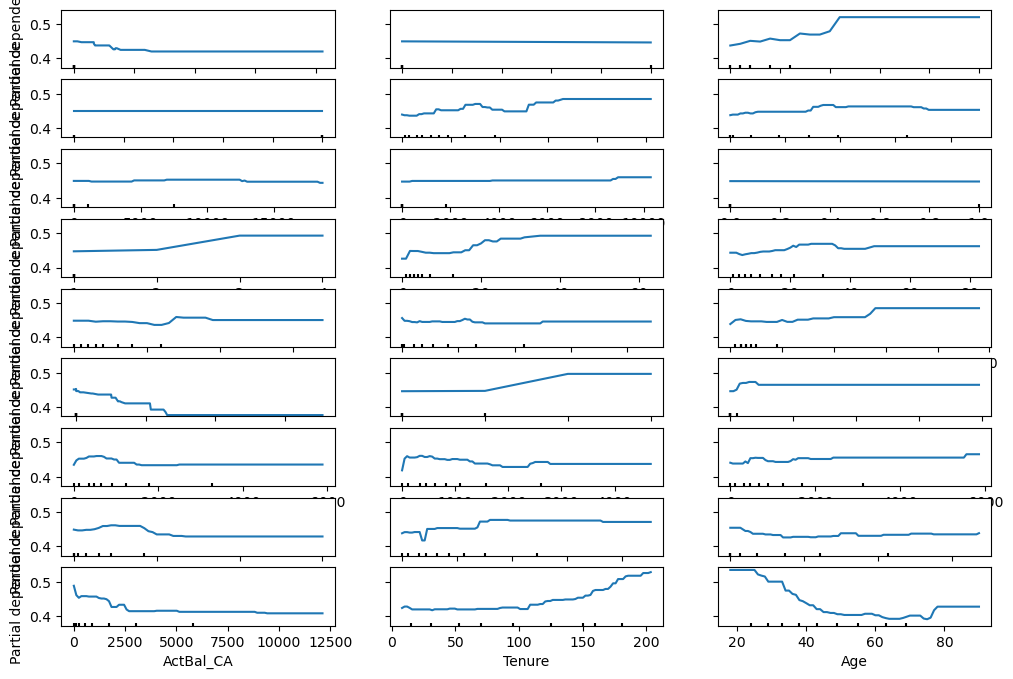

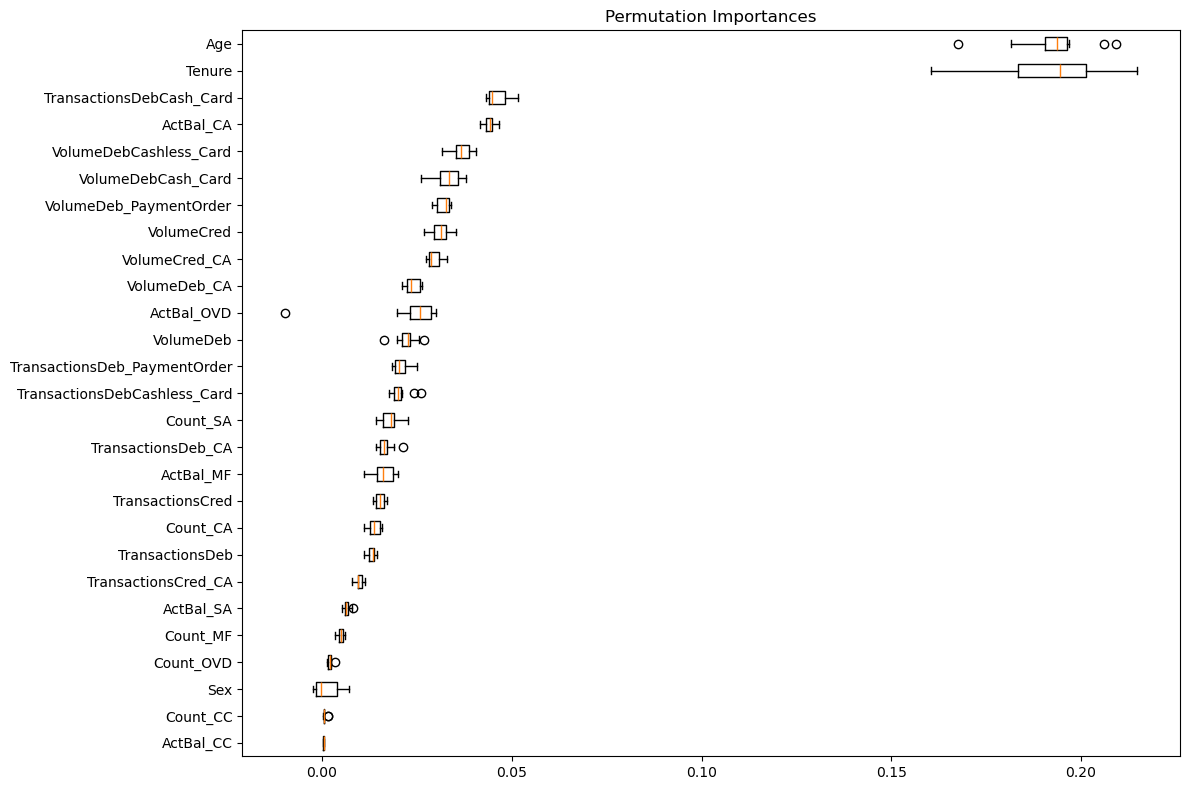

In [29]:
feature_importance_Revenue_CL = visualize_permutation_importance(m_Revenue_CL, df_train_CL_X, df_train_Revenue_CL_Y)

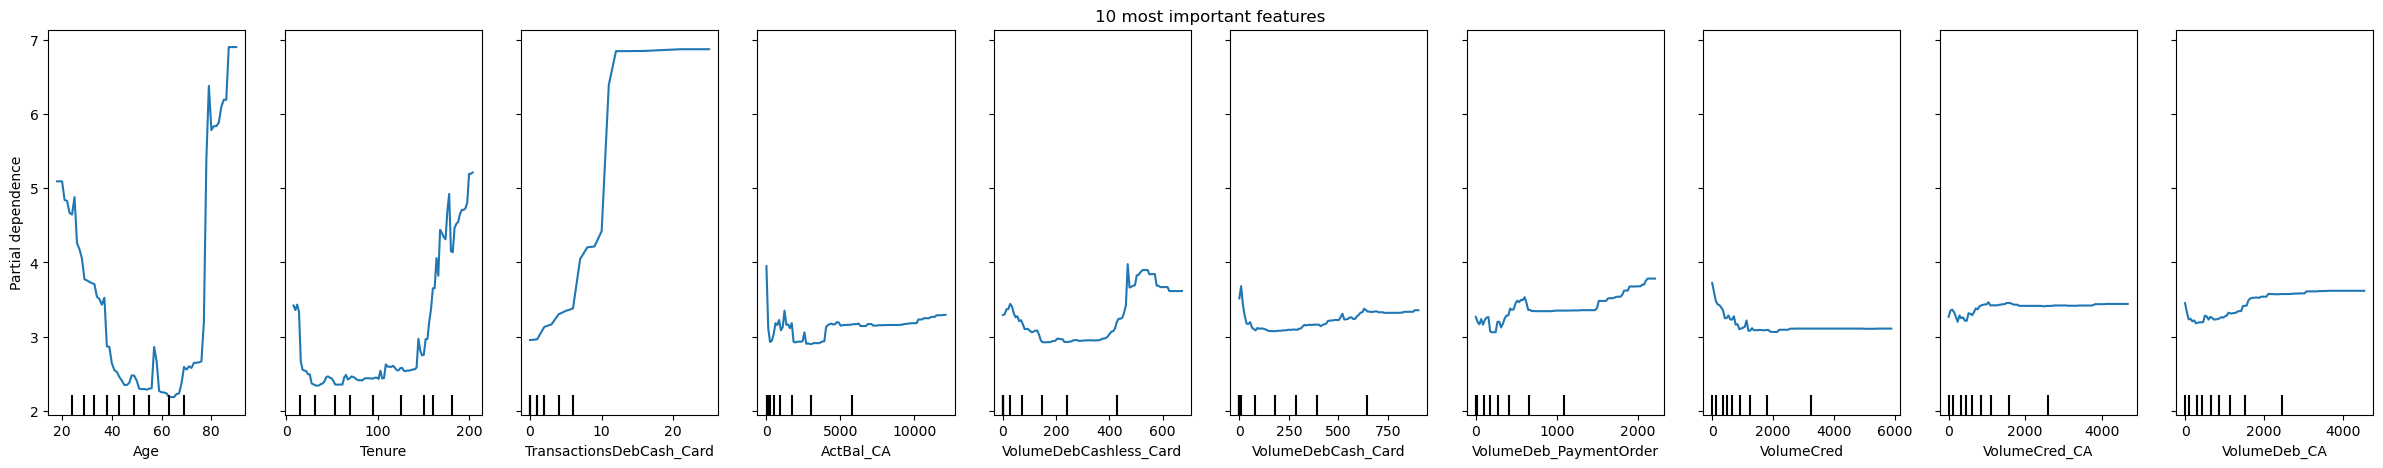

In [30]:

def visualize_partial_dependence(m, df_X, sorted_idx, threshold=10):
    # Prepare the plot
    fig, ax = plt.subplots(figsize=(30, 5))
    ax.set_title("%d most important features" % threshold)
    
    # Create the PartialDependenceDisplay
    PartialDependenceDisplay.from_estimator(
        m, 
        df_X, 
        features=df_X.columns[sorted_idx][::-1][:threshold],  # Select features based on sorted_idx
        n_cols=threshold,
        n_jobs=-1,
        grid_resolution=100,
        ax=ax
    )
    plt.show()

# Now call your function
visualize_partial_dependence(m_Revenue_CL, df_train_CL_X, feature_importance_Revenue_CL)

While certain trends align with the previous model, which is expected, notable differences emerge. For example, according to the model, a higher number of monthly debit transactions via card appears to influence the revenue generated from a client.

The key features associated with profitable consumer loan clients were identified as Age, Tenure, TransactionsDebCash_Card (monthly number of debit cash transactions via card), ActBal_CA, and VolumeDebCashless_Card.

Profitable consumer loan clients tend to be younger or long-term, loyal clients, including retired individuals. These clients typically have low balances in their current and savings accounts, but they engage in more debit card transactions. They also maintain higher balances in their current accounts and exhibit a larger volume of cashless card transactions.

## Credit Card Data

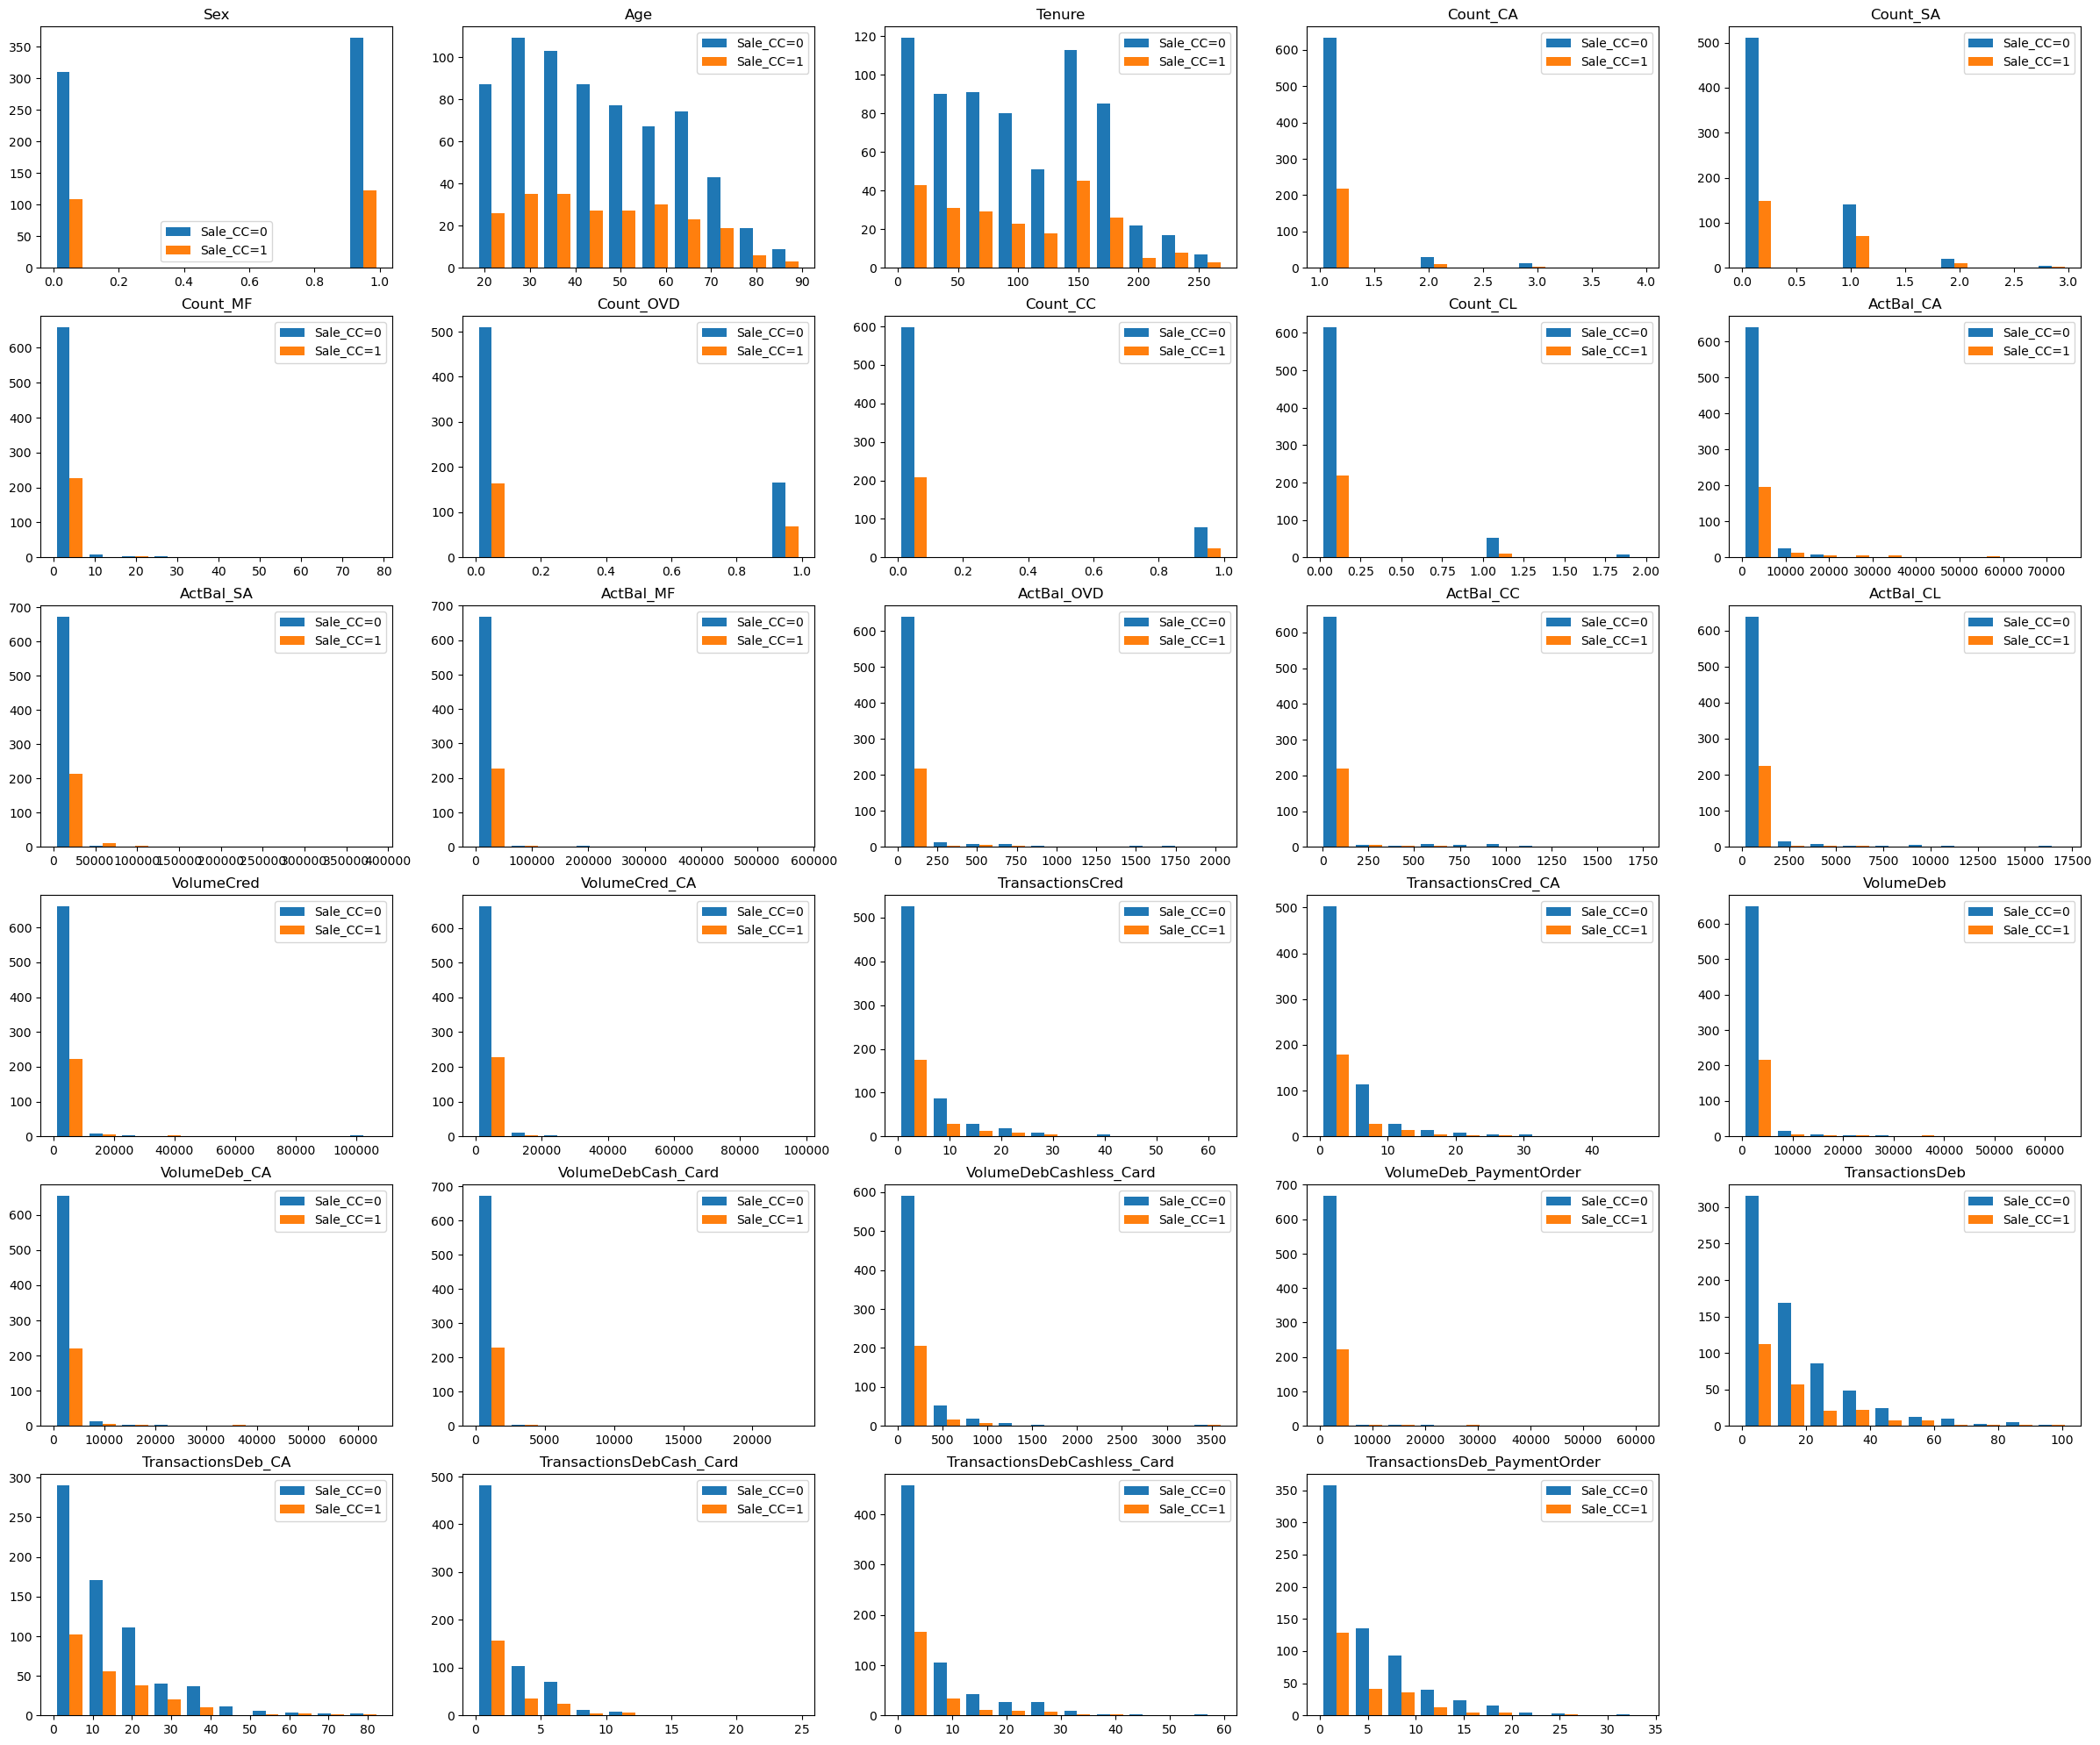

In [31]:
compare_binary_class_difference('Sale_CC')

In [32]:
features_CC = ['Sex', 'Age', 'Tenure',
               'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CL',
               'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CL',
               'VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
               'TransactionsCred_CA', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
df_train_CC_X = df_train[features_CC]
df_train_Sale_CC_Y = df_train[['Sale_CC']].to_numpy().flatten()
df_train_Revenue_CC_Y = df_train[['Revenue_CC']].to_numpy().flatten()

In [33]:
m_Sale_CC = train_classification_model(df_train_CC_X, df_train_Sale_CC_Y,
                                       criterion='entropy',
                                       n_estimators=50,
                                       min_samples_split=50,
                                       min_samples_leaf=3)

Training set metrics:
Accuracy:  0.8950276243093923
Precision: 0.7951807228915663
Recall:    0.7586206896551724
AUC:       0.950700104493208
-----------------------------
Test set metrics:
Accuracy:  0.7307692307692307
Precision: 0.6428571428571429
Recall:    0.3157894736842105
AUC:       0.6314385964912281


/var/folders/n4/vr9czyr51kz3wp717sbrf_3c0000gp/T/ipykernel_79166/2226445234.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T,


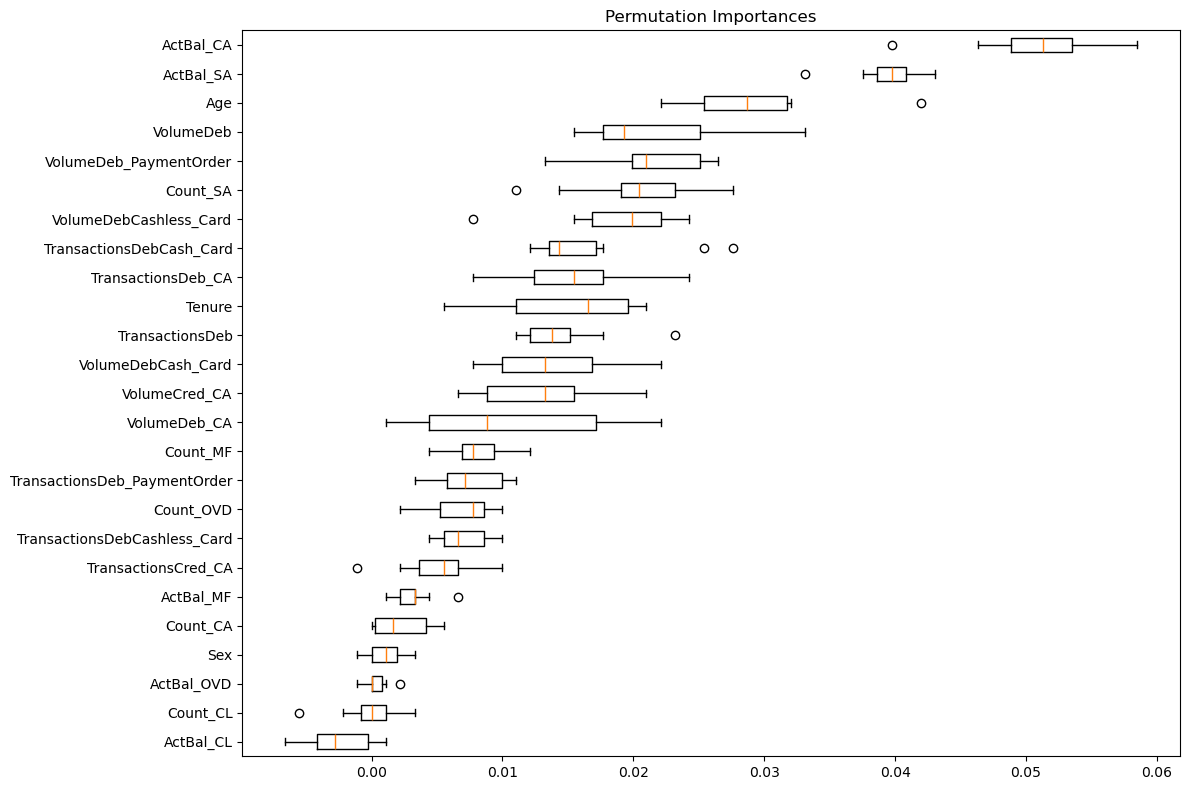

In [34]:
feature_importance_Sale_CC = visualize_permutation_importance(m_Sale_CC, df_train_CC_X, df_train_Sale_CC_Y)

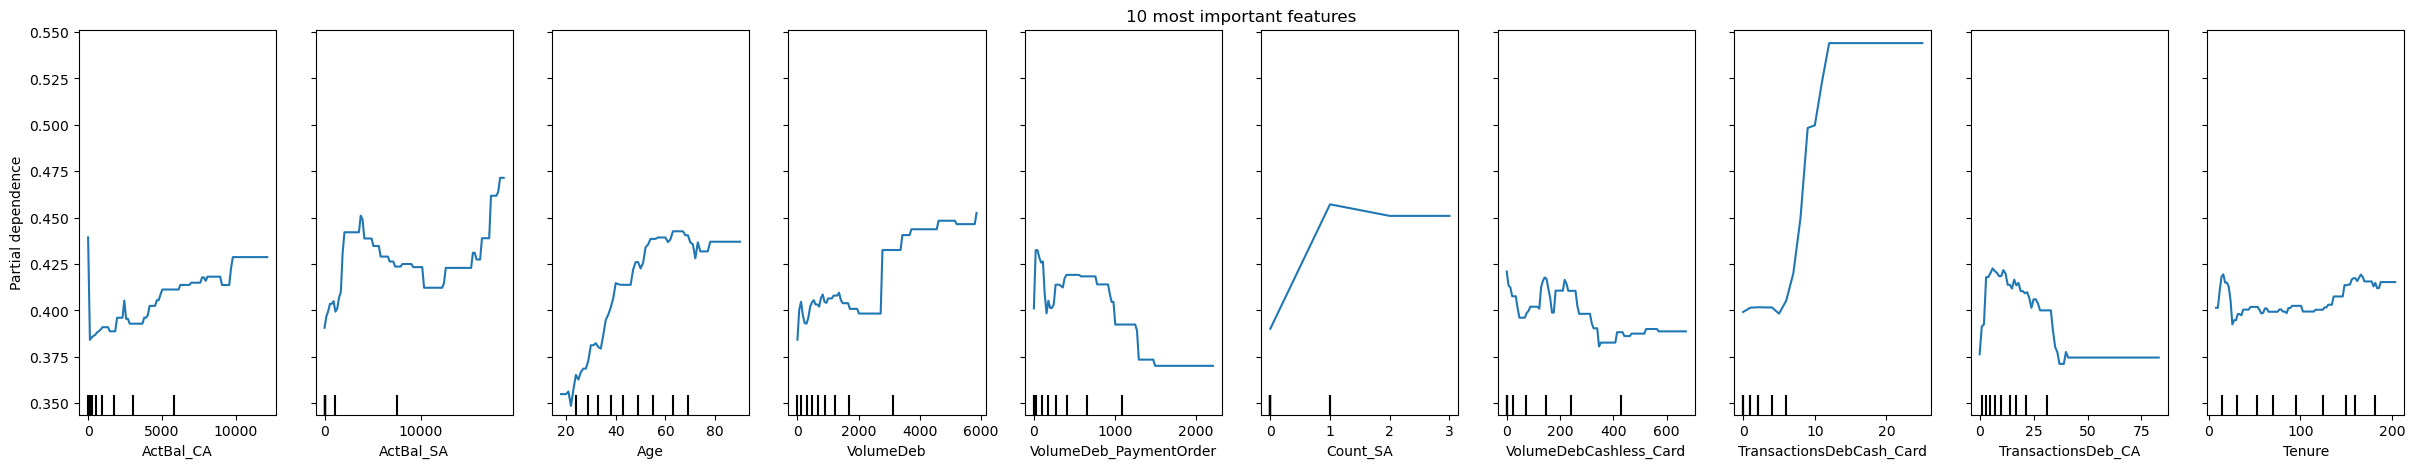

In [35]:
visualize_partial_dependence(m_Sale_CC, df_train_CC_X, feature_importance_Sale_CC)

The key features identified when predicting the likelihood of purchasing a credit card were ActBal_CA, ActBal_SA, Age, VolumeDeb (monthly debit turnover), VolumeDebPaymentOrder (monthly volume of debit transactions via payment order), and Count_SA.

Clients most likely to acquire a credit card tend to be older and have more than 2500 EUR in their current account. They often also have a savings account, with clients holding over 15,000 EUR in it being more inclined to purchase a credit card. These clients also tend to have a high monthly debit turnover (over 3000 EUR) and generally make fewer debit transactions via payment orders.

### 2.2.2 Credit Card Revenue

In [36]:
m_Revenue_CC = train_regression_model(df_train_CC_X, df_train_Revenue_CC_Y,
                                      n_estimators=1000,
                                      criterion='squared_error',
                                      max_depth=20,
                                      min_samples_split=5,
                                      min_samples_leaf=5)

RMSE (Training set): 11.525
RMSE (Test set):     31.864



/var/folders/n4/vr9czyr51kz3wp717sbrf_3c0000gp/T/ipykernel_79166/2226445234.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T,


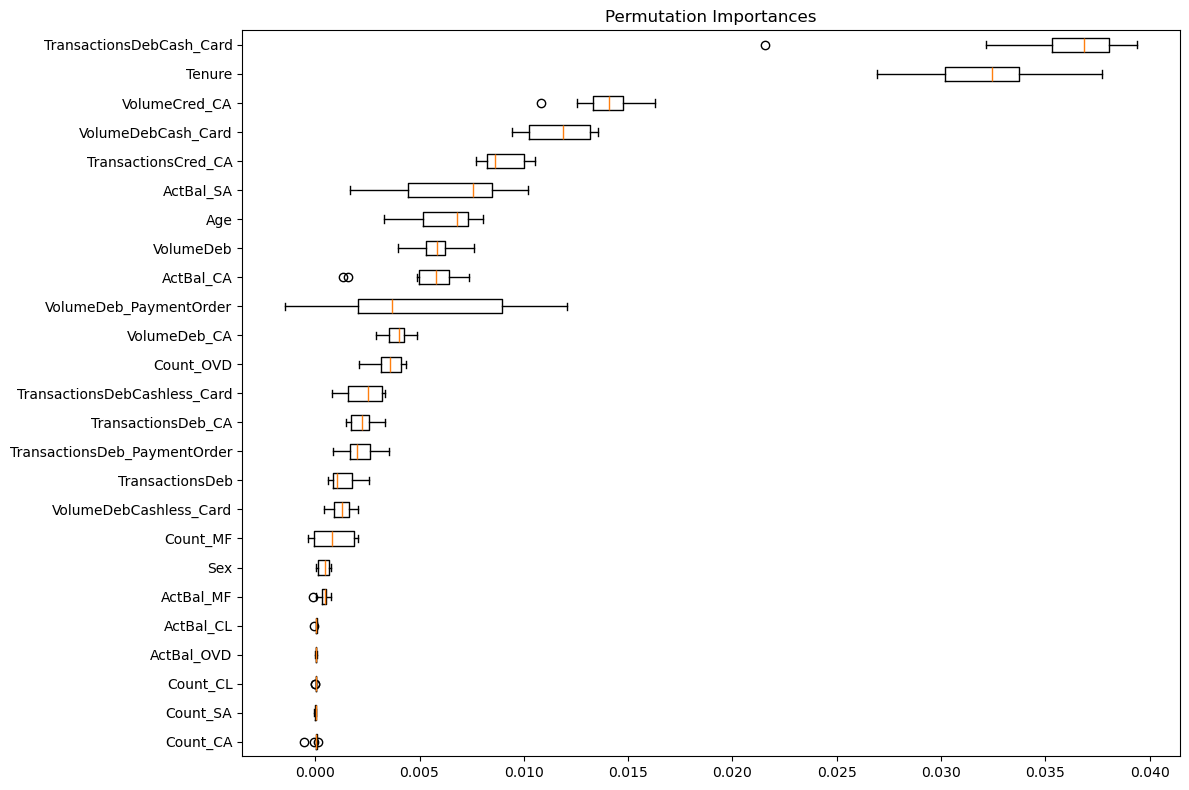

In [37]:
feature_importance_Revenue_CC = visualize_permutation_importance(m_Revenue_CC, df_train_CC_X, df_train_Revenue_CC_Y)

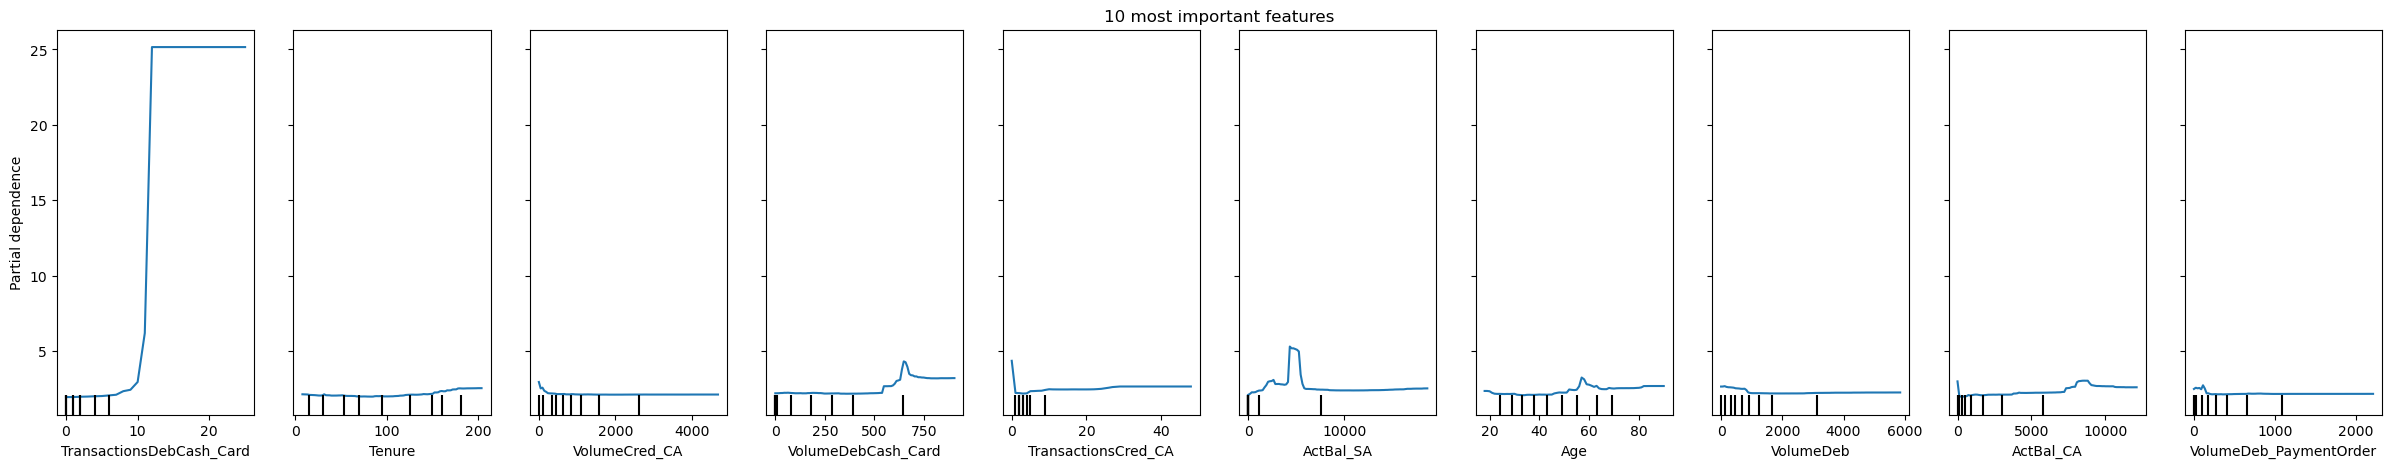

In [38]:
visualize_partial_dependence(m_Revenue_CC, df_train_CC_X, feature_importance_Revenue_CC)


The key features identified for profitable credit card clients were TransactionsDebCash_Card (monthly number of debit cash transactions via card), Tenure, VolumeCred_CA (monthly credit turnover on current accounts), and VolumeDebCash_Card (monthly volume of debit cash transactions via card).

Profitable clients for credit card purchases tend to have a high number of debit cash transactions via card and have been with the bank for a longer period. They generally have a lower credit turnover on their current accounts but tend to make a higher volume of debit cash transactions.

## 2.3 Mutual Fund Data

### 2.3.1 Mutual Fund Sale

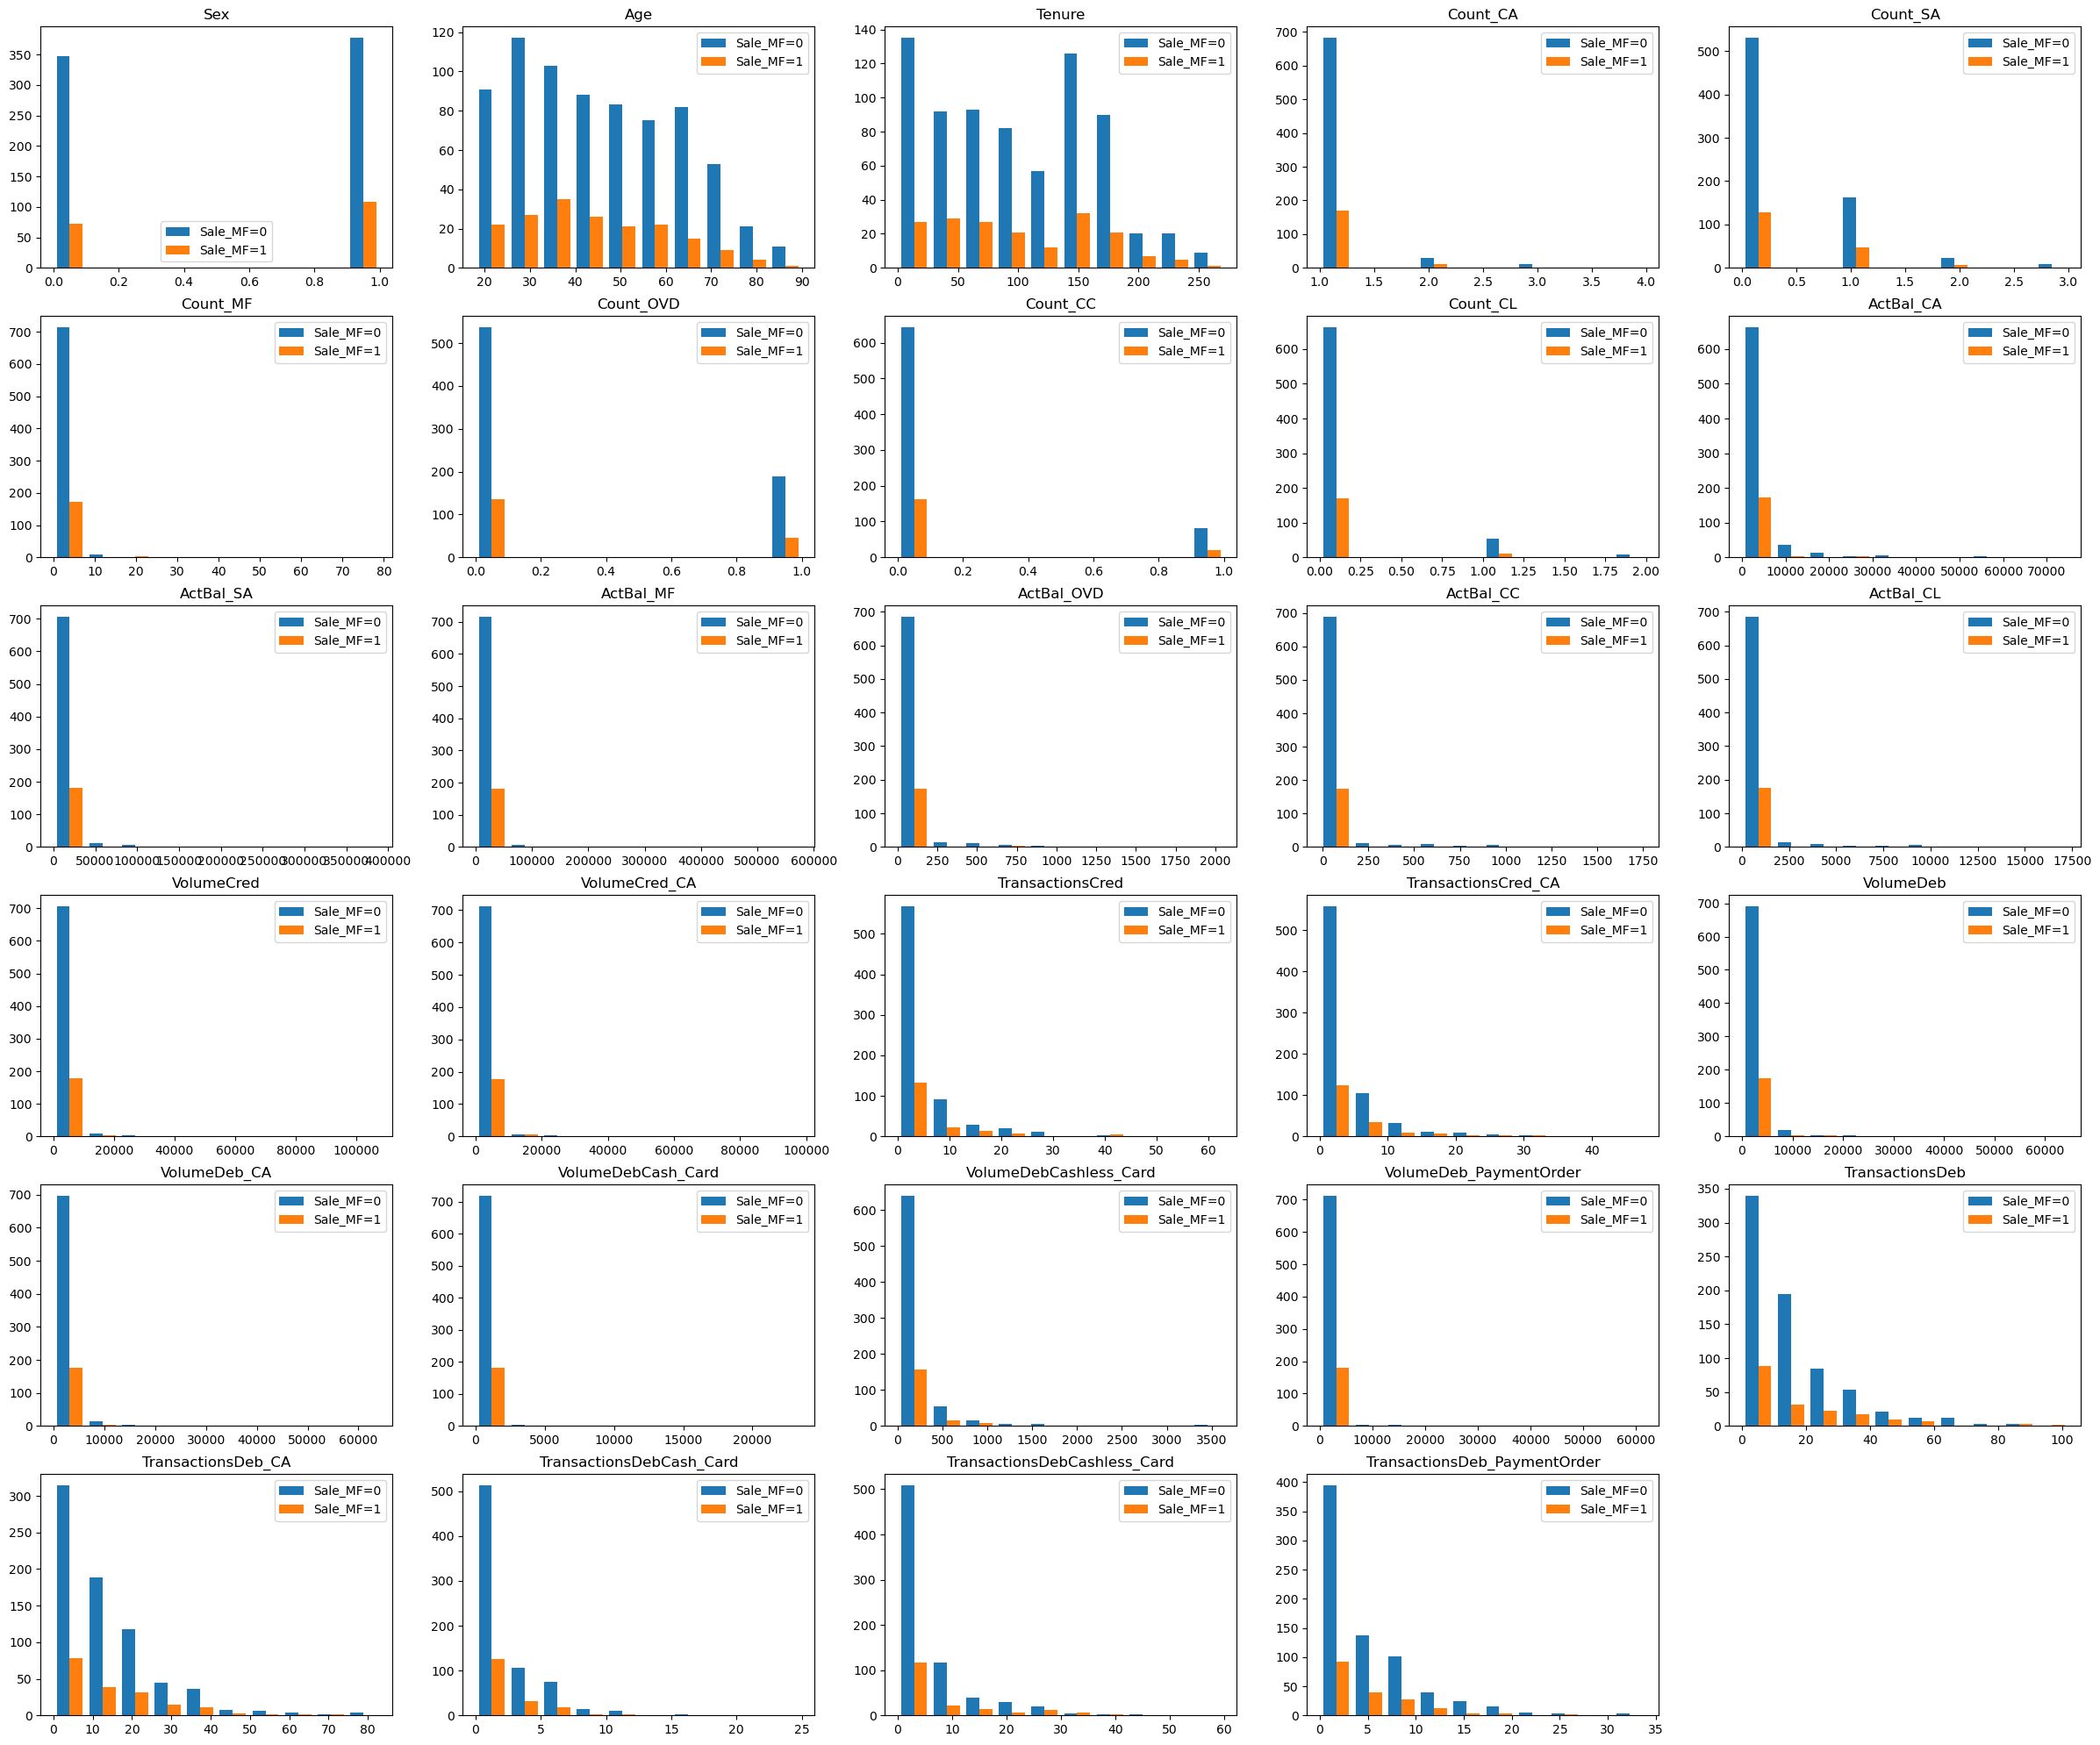

In [39]:
compare_binary_class_difference('Sale_MF')

In [40]:
features_MF = ['Sex', 'Age', 'Tenure',
               'Count_CA', 'Count_SA', 'Count_CL', 'Count_OVD', 'Count_CC',
               'ActBal_CA', 'ActBal_SA', 'ActBal_CL', 'ActBal_OVD', 'ActBal_CC',
               'VolumeCred', 'VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
               'TransactionsCred', 'TransactionsCred_CA', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
df_train_MF_X = df_train[features_MF]
df_train_Sale_MF_Y = df_train[['Sale_MF']].to_numpy().flatten()
df_train_Revenue_MF_Y = df_train[['Revenue_MF']].to_numpy().flatten()

In [41]:
m_Sale_MF = train_classification_model(df_train_MF_X, df_train_Sale_MF_Y,
                                       criterion='entropy',
                                       n_estimators=45,
                                       min_samples_split=50,
                                       min_samples_leaf=10)

Training set metrics:
Accuracy:  0.8950276243093923
Precision: 0.7446808510638298
Recall:    0.7241379310344828
AUC:       0.9398606396283723
-----------------------------
Test set metrics:
Accuracy:  0.7582417582417582
Precision: 0.36
Recall:    0.24324324324324326
AUC:       0.6445479962721342


/var/folders/n4/vr9czyr51kz3wp717sbrf_3c0000gp/T/ipykernel_79166/2226445234.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T,


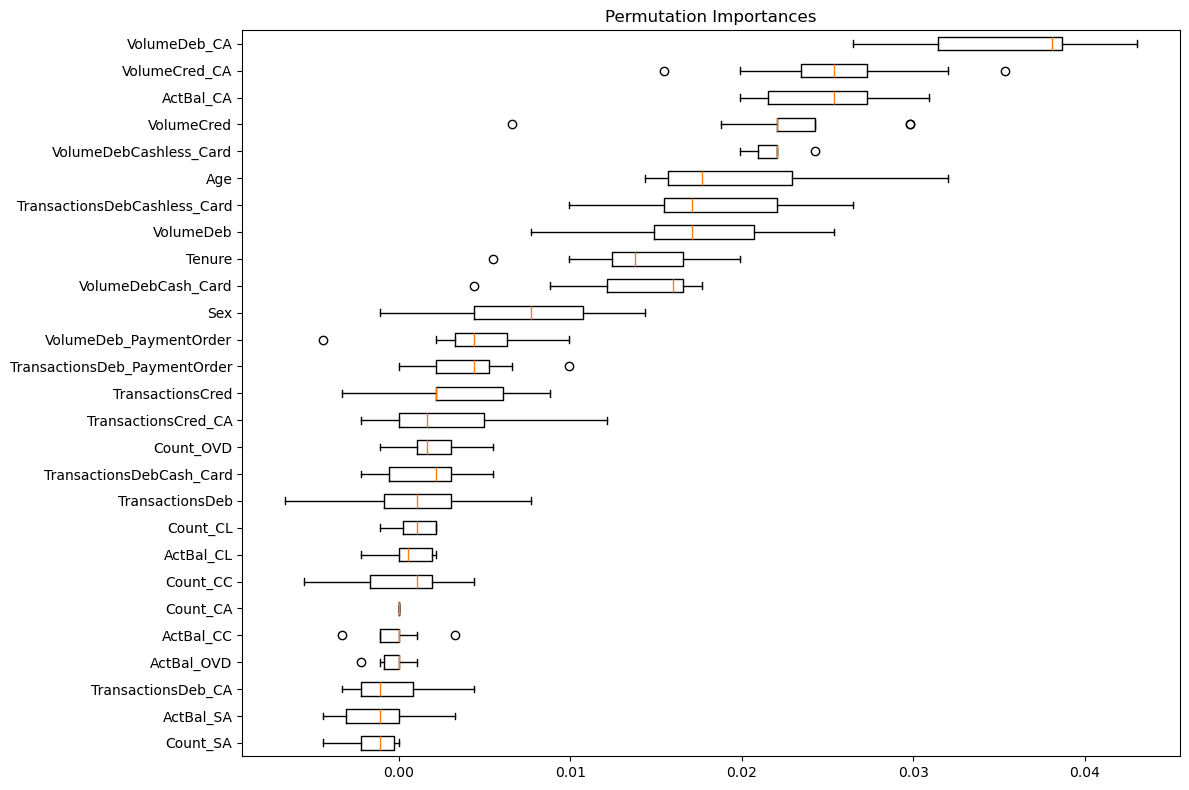

In [42]:
feature_importance_Sale_MF = visualize_permutation_importance(m_Sale_MF, df_train_MF_X, df_train_Sale_MF_Y)

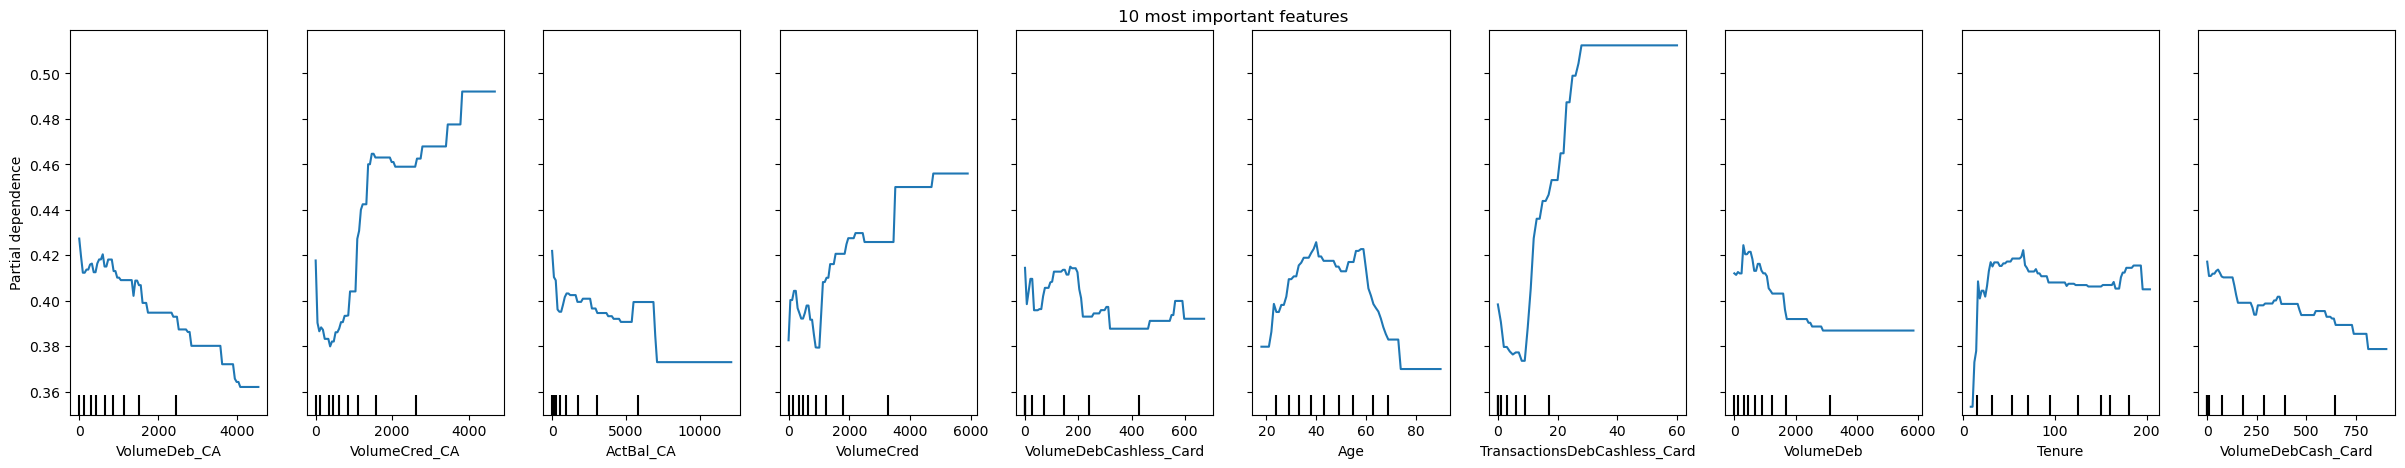

In [43]:
visualize_partial_dependence(m_Sale_MF, df_train_MF_X, feature_importance_Sale_MF)

When predicting the likelihood of a customer purchasing a mutual fund, the most important features identified were VolumeDeb_CA, VolumeCred_CA, ActBal_CA, VolumeCred, and Age.

Clients most likely to purchase a mutual fund are typically between 30 and 60 years old, with a lower debit turnover and smaller balance in their current accounts. However, they tend to have a higher credit turnover both in their current accounts and overall.

### Mutual Fund Revenue

In [44]:
m_Revenue_MF = train_regression_model(df_train_MF_X, df_train_Revenue_MF_Y,
                                      n_estimators=100,
                                      criterion='squared_error',
                                      max_depth=12,
                                      min_samples_split=3,
                                      min_samples_leaf=2)

RMSE (Training set): 6.390
RMSE (Test set):     11.079



/var/folders/n4/vr9czyr51kz3wp717sbrf_3c0000gp/T/ipykernel_79166/2226445234.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T,


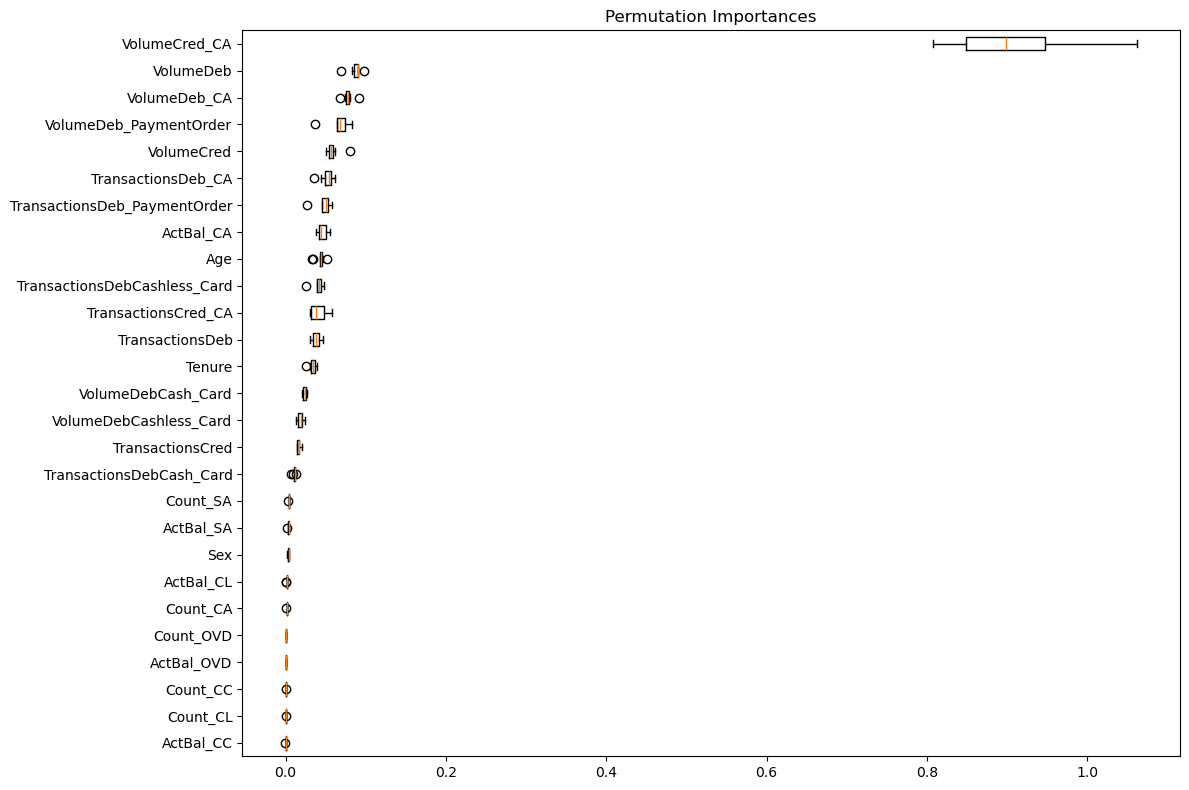

In [45]:
feature_importance_Revenue_MF = visualize_permutation_importance(m_Revenue_MF, df_train_MF_X, df_train_Revenue_MF_Y)

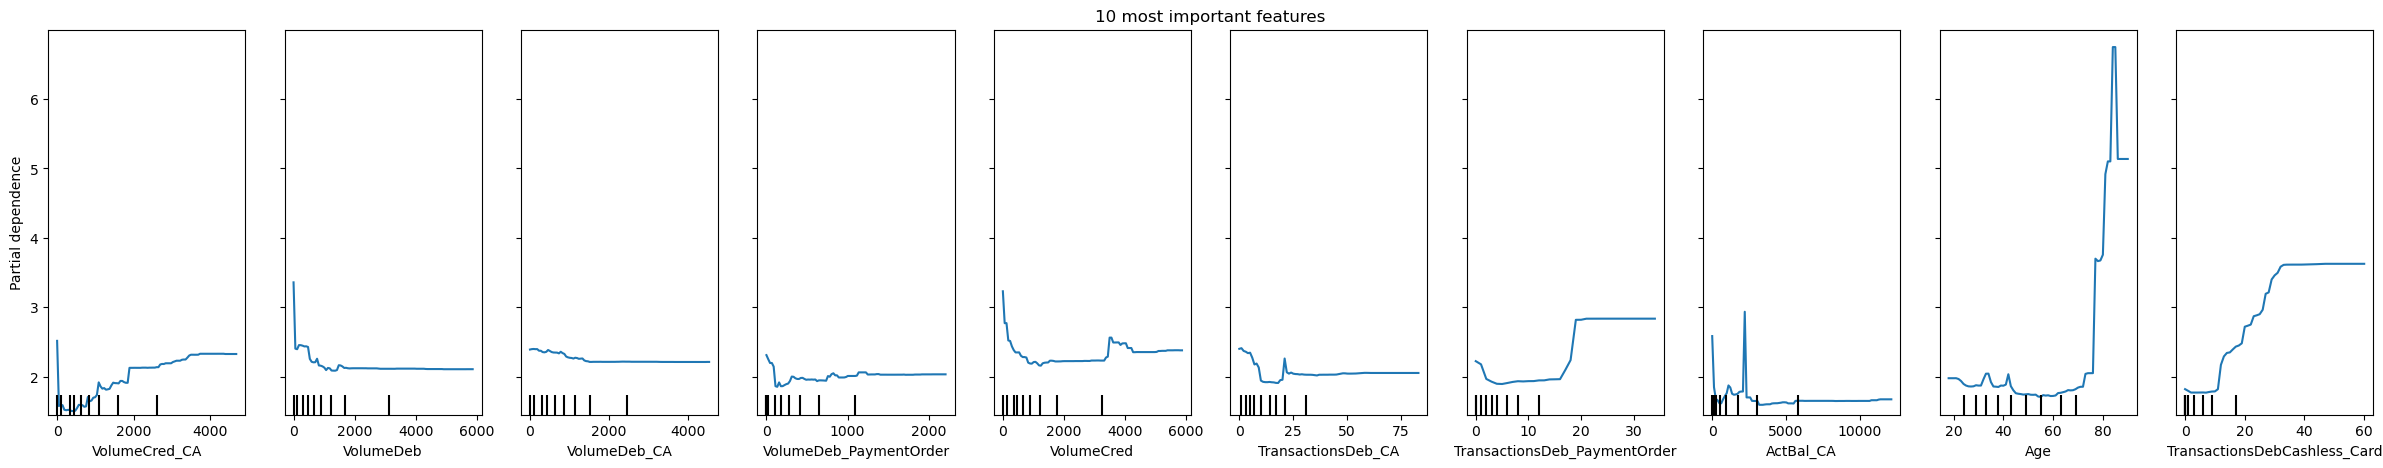

In [46]:
visualize_partial_dependence(m_Revenue_MF, df_train_MF_X, feature_importance_Revenue_MF)

The key features of profitable clients for mutual funds identified were VolumeCred_CA, VolumeDeb, VolumeDeb_CA, VolumeDeb_PaymentOrder, and VolumeCred.

The model for identifying profitable mutual fund clients is primarily influenced by the monthly turnover in clients' accounts. Specifically, there appears to be a relationship between the profitability of clients with mutual funds and their tendency to make smaller debit transactions, both generally and from their current accounts. In terms of credit transactions, clients with either very low or very high transaction volumes tend to be the most favorable for the bank.

# Client Targeting

The set of clients to be targeted by the bank's marketing campaign is determined by maximizing the expected revenue. The task is constrained by the bank’s capacity to contact only 15% of the clients with a marketing offer, and each client can be targeted only once.

The maximum expected revenue for each client is calculated as the product of the probability that the client will purchase a service and the expected revenue from that client.

The top 15% (90) of clients with the highest expected revenue have been identified, along with the specific product they should be targeted with in the direct marketing campaign.

To enhance the potential profitability of the solution, it could be beneficial to allow targeted offers for customers who have already purchased at least one of the three services (i.e., customers in the training set) but have not yet purchased the other services. For example, a customer who already holds a credit card but does not have a consumer loan could be included in the prediction dataset for the sale/profitability of consumer loans, as they would be a valid candidate. This option is not currently available, as per the constraints outlined in the task description.

#### Compute consumer loan data predictions

In [47]:
# predict the probability of the client purchasing a consumer loan
predicted_Sale_CL = m_Sale_CL.predict_proba(df_guess[features_CL])[:,1]
# predict the revenue from the client with the consumer loan
predicted_Revenue_CL = m_Revenue_CL.predict(df_guess[features_CL])
# store in dataframe
df_guess = df_guess.assign(pred_Sale_CL=predicted_Sale_CL,
                           pred_Revenue_CL=predicted_Revenue_CL,
                           ExpectedRevenue_CL=predicted_Sale_CL * predicted_Revenue_CL)

#### Compute credit card data predictions

In [48]:
# predict the probability of the client purchasing a credit card
predicted_Sale_CC = m_Sale_CC.predict_proba(df_guess[features_CC])[:,1]
# predict the revenue from the client with the credit card
predicted_Revenue_CC = m_Revenue_CC.predict(df_guess[features_CC])
# store in dataframe
df_guess = df_guess.assign(pred_Sale_CC=predicted_Sale_CC,
                           pred_Revenue_CC=predicted_Revenue_CC,
                           ExpectedRevenue_CC=predicted_Sale_CC * predicted_Revenue_CC)

#### Compute mutual fund data predictions

In [49]:
# predict the probability of the client purchasing a mutual fund
predicted_Sale_MF = m_Sale_MF.predict_proba(df_guess[features_MF])[:,1]
# predict the revenue from the client with the mutual fund
predicted_Revenue_MF = m_Revenue_MF.predict(df_guess[features_MF])
# store in dataframe
df_guess = df_guess.assign(pred_Sale_MF=predicted_Sale_MF,
                           pred_Revenue_MF=predicted_Revenue_MF,
                           ExpectedRevenue_MF=predicted_Sale_MF * predicted_Revenue_MF)

### Compute overall results

In [50]:
# compute & store maximum expected revenue of a client and the source (service) of that value
df_guess = df_guess.assign(pred_Offer=df_guess[['ExpectedRevenue_CL', 'ExpectedRevenue_CC', 'ExpectedRevenue_MF']].idxmax(axis=1))
df_guess = df_guess.assign(pred_Revenue=df_guess[['ExpectedRevenue_CL', 'ExpectedRevenue_CC', 'ExpectedRevenue_MF']].max(axis=1))

In [51]:
# replace revenue source descripion string
df_guess.replace(regex=r'^ExpectedRevenue_', value='', inplace=True)
# get the clients to target by the marketing campaign
fifteen_perc = int(0.15 * df_guess.shape[0])
target_group = df_guess.sort_values(by='pred_Revenue', ascending=False)[['pred_Offer', 'pred_Revenue']].head(fifteen_perc)

For future research, it could be valuable to visualize how each model contributes to the total revenue.

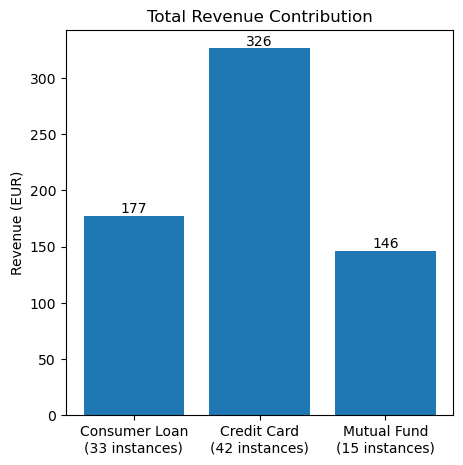

In [52]:
revenue_CL = sum(target_group[target_group['pred_Offer'] == 'CL']['pred_Revenue'])
n_CL_instances = target_group[target_group['pred_Offer'] == 'CL'].shape[0]
revenue_CC = sum(target_group[target_group['pred_Offer'] == 'CC']['pred_Revenue'])
n_CC_instances = target_group[target_group['pred_Offer'] == 'CC'].shape[0]
revenue_MF = sum(target_group[target_group['pred_Offer'] == 'MF']['pred_Revenue'])
n_MF_instances = target_group[target_group['pred_Offer'] == 'MF'].shape[0]

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("Total Revenue Contribution")
bars = plt.bar(x=['Consumer Loan\n(%d instances)' % n_CL_instances, 'Credit Card\n(%d instances)' % n_CC_instances, 'Mutual Fund\n(%d instances)' % n_MF_instances],
               height=[revenue_CL, revenue_CC, revenue_MF])
for rect in bars:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom')

plt.ylabel("Revenue (EUR)")
plt.show()

We observe that the credit card marketing campaign contributes the most to the overall revenue of the campaign, surpassing the combined revenue of the other two campaigns (considering the constraints). However, the mutual fund campaign generates the highest profit per client targeted. It could be insightful to explore mutual fund marketing efforts in more detail in a separate objective/project.

In [53]:
# Revenue
with pd.option_context('display.max_rows', None):
    print(target_group.rename(columns={'pred_Offer': 'Offer','pred_Revenue': 'Revenue (EUR)'}))
    
print('Expected revenue of the strategy: %.2f EUR.' % sum(target_group.pred_Revenue))

       Offer  Revenue (EUR)
Client                     
766       MF      28.608299
110       MF      17.010545
596       MF      16.643523
401       CC      16.413794
331       CC      15.665231
516       CC      15.569934
1296      CC      14.610052
931       CC      14.585340
200       MF      14.298376
1365      CC      14.033400
1443      CC      13.832954
996       CC      13.588911
373       CC      12.840219
532       MF      12.538967
153       CC      11.106545
506       MF      10.984268
41        CL      10.739884
84        CC      10.610395
866       CC      10.530806
496       CC      10.294612
206       CC       8.618473
330       MF       8.579085
674       CL       8.519574
1119      CL       7.671397
389       CC       7.657399
1455      CC       7.204251
1373      CL       7.031235
1349      CC       6.984874
197       CC       6.958265
265       MF       6.788368
706       CC       6.630801
562       CL       6.569965
1077      CC       6.081744
454       CC       6